### Проект «Линейные модели в машинном обучении».

Цель проекта - разработать две прогнозные модели машинного обучения, которые помогут фермеру отобрать коров для покупки по двум критериям:
 - средний удой за год — не менее 6000 килограммов;
 - молоко должно быть вкусным.
 
***Первая модель*** будет прогнозировать возможный удой коровы.

***Вторая модель*** будет рассчитывать вероятность получить вкусное молоко от коровы.

**План работ:**

***1)*** Загрузить и изучить информацию из файлов 'ferma_main.csv', 'ferma_dad.csv', 'cow_buy.csv', подготовить данные для последующего анализа.
- откорректировать названия столбцов;
- выявить пропуски, избавиться от них, если они есть;
- избавиться от явных и неявных дубликатов.

***2)*** Провести исследовательский анализ данных:
- провести статистический анализ всех признаков;
- построить графики для каждого признака: гистограммы, диаграммы размаха для количественных и круговые диаграммы для категориальных.
- проверить данные на выбросы, аномалии, избавиться от аномалий.

***3)*** Провести корреляционный анализ данных:
- рассчитать коэффициенты корреляции между всеми признаками;
- построить диаграммы рассеяния scatterplot для признака Удой и всех количественных признаков с учётом значения категориальных признаков;
- определить типы связи между целевым и входными признаками;
- выявить мультиколлинеарность между входными признаками.

***4)*** Построить и обучить 3 модели линейной регрессии:
- отобрать признаки для трех моделей, обучить;
- сравнить качество трёх моделей линейной регрессии, сопоставить их R², остатки, показатели mse, rmse, mae.
- выявить лучшую модель, посчитать доверительный интервал для лучшей модели.

***5)*** С помощью лучшей модели спрогнозировать удой коров, которых фермер хочет купить.

***6)*** Построить и обучить модель логистической регрессии:
- отобрать признаки, подходящие для построения прогноза, и подготовить данные;
- обучить модель на подготовленных данных;
- оценить качество модели на тестовой выборке, рассчитать метрики accuracy, recall, precision.
- построить матрицу ошибок.

***7)*** Проанализировать модель логистической регрессии:
- объяснить, какая метрика recall и precision, лучше подойдет для определеия качества модели;
- свести критичную ошибку к нулю, изменив порог принадлежности к классам;
- с помощью обученной модели спрогнозировать вкус молока коров, которых фермер хочет купить. 

***8)*** Сделать итоговые выводы:
- добавить прогнозы вкуса молока и удоя коров «ЭкоФермы» в датафрейм с коровами, покупку которых рассматривает фермер;
- ототбрать коров, для которых спрогнозирован удой более 6000 килограммов в год и вкусное молоко;
- дать рекомендации фермеру, сколько коров он может купить из стада на продажу с минимальным риском для себя;
- сделать выводы о способах улучшения качества регрессионной модели;
- объяснить, какие метрики логистической регрессии важны при анализе рисков или экономических расчётов.

## Загрузка данных

In [1]:
!pip install phik -q

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import scipy.stats as st
import seaborn as sns
import random

RANDOM_STATE = 42

from phik import resources, report
from sklearn.datasets import make_classification
from sklearn.linear_model import (
                                  LinearRegression,
                                  LogisticRegression
                                 )
from sklearn.preprocessing import (
                                  StandardScaler,
                                  OneHotEncoder
                                  )
from sklearn.metrics import (
                            confusion_matrix,
                            mean_squared_error,
                            mean_absolute_error,
                            r2_score,
                            recall_score,
                            precision_score,
                            accuracy_score
                            )
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split

from scipy.stats import spearmanr


Загрузим файлы

In [3]:
ferma_main = pd.read_csv('https://code.s3.yandex.net/datasets/ferma_main.csv', delimiter=";", decimal=",")
ferma_dad = pd.read_csv('https://code.s3.yandex.net/datasets/ferma_dad.csv', delimiter=";")
cow_buy = pd.read_csv('https://code.s3.yandex.net/datasets/cow_buy.csv', delimiter=";", decimal=",")

Посмотрим информацию в таблице 'ferma_main'

In [4]:
display(ferma_main.head())
ferma_main.info()

id  Удой, кг  ЭКЕ (Энергетическая кормовая единица)  Сырой протеин, г  \
0   1      5863                                   14.2              1743   
1   2      5529                                   12.8              2138   
2   3      5810                                   14.0              1854   
3   4      5895                                   12.4              2012   
4   5      5302                                   12.8              1675   

   СПО (Сахаро-протеиновое соотношение)           Порода Тип пастбища  \
0                                 0.890   Вис Бик Айдиал    Равнинное   
1                                 0.890   Вис Бик Айдиал    Равнинные   
2                                 0.885  РефлешнСоверинг    Холмистое   
3                                 0.885  РефлешнСоверинг    Холмистое   
4                                 0.885   Вис Бик Айдиал    Равнинные   

  порода папы_быка  Жирность,%  Белок,% Вкус молока      Возраст  
0           Айдиал        3.58    3.076      вкусно  более_2_лет  
1          Соверин        3.54    3.079      вкусно  менее_2_лет  
2          Соверин        3.59    3.074   не вкусно  более_2_лет  
3           Айдиал        3.40    3.075   не вкусно  более_2_лет  
4          Соверин        3.73    3.073      вкусно  менее_2_лет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 
 11  Возрас

Переименуем столбцы.

In [5]:
ferma_main.columns = ['id', 'yield_kg', 'eke', 'raw_protein', 'sugar_prot_rate', 'breed',
                      'pasture', 'dad_breed', 'fat_%', 'protein_%', 'taste', 'age']
display(ferma_main.head())
ferma_main.info()

id  yield_kg   eke  raw_protein  sugar_prot_rate            breed  \
0   1      5863  14.2         1743            0.890   Вис Бик Айдиал   
1   2      5529  12.8         2138            0.890   Вис Бик Айдиал   
2   3      5810  14.0         1854            0.885  РефлешнСоверинг   
3   4      5895  12.4         2012            0.885  РефлешнСоверинг   
4   5      5302  12.8         1675            0.885   Вис Бик Айдиал   

     pasture dad_breed  fat_%  protein_%      taste          age  
0  Равнинное    Айдиал   3.58      3.076     вкусно  более_2_лет  
1  Равнинные   Соверин   3.54      3.079     вкусно  менее_2_лет  
2  Холмистое   Соверин   3.59      3.074  не вкусно  более_2_лет  
3  Холмистое    Айдиал   3.40      3.075  не вкусно  более_2_лет  
4  Равнинные   Соверин   3.73      3.073     вкусно  менее_2_лет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               634 non-null    int64  
 1   yield_kg         634 non-null    int64  
 2   eke              634 non-null    float64
 3   raw_protein      634 non-null    int64  
 4   sugar_prot_rate  634 non-null    float64
 5   breed            634 non-null    object 
 6   pasture          634 non-null    object 
 7   dad_breed        634 non-null    object 
 8   fat_%            634 non-null    float64
 9   protein_%        634 non-null    float64
 10  taste            634 non-null    object 
 11  age              634 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 59.6+ KB


Изучим данные в таблице 'ferma_dad'.

In [6]:
print(ferma_dad.head())
ferma_dad.info()

   id  Имя Папы
0   1    Буйный
1   2  Соловчик
2   3     Барин
3   4    Буйный
4   5     Барин
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


Переименуем второй столбец.

In [7]:
ferma_dad.rename(columns = {'Имя Папы':'dad_name'}, inplace = True)
list(ferma_dad.columns)

['id', 'dad_name']

Изучим данные в таблице 'cow_buy'.

In [8]:
display(cow_buy.head())
cow_buy.info()

Порода Тип пастбища порода папы_быка  Имя_папы  \
0   Вис Бик Айдиал    холмистое           Айдиал  Геркулес   
1   Вис Бик Айдиал    равнинное          Соверин    Буйный   
2  РефлешнСоверинг    равнинное          Соверин     Барин   
3  РефлешнСоверинг    холмистое           Айдиал    Буйный   
4  РефлешнСоверинг    равнинное           Айдиал    Буйный   

   Текущая_жирность,%  Текущий_уровень_белок,%      Возраст  
0                3.58                    3.076  более_2_лет  
1                3.54                    3.081  менее_2_лет  
2                3.59                    3.074  более_2_лет  
3                3.40                    3.061  более_2_лет  
4                3.64                    3.074  более_2_лет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


Переименуем столбцы.

In [8]:
cow_buy.columns = ['breed', 'pasture', 'dad_breed', 'dad_name', 'current_fat_%', 'current_protein_%', 'age']
display(cow_buy.head())
cow_buy.info()

breed    pasture dad_breed  dad_name  current_fat_%  \
0   Вис Бик Айдиал  холмистое    Айдиал  Геркулес           3.58   
1   Вис Бик Айдиал  равнинное   Соверин    Буйный           3.54   
2  РефлешнСоверинг  равнинное   Соверин     Барин           3.59   
3  РефлешнСоверинг  холмистое    Айдиал    Буйный           3.40   
4  РефлешнСоверинг  равнинное    Айдиал    Буйный           3.64   

   current_protein_%          age  
0              3.076  более_2_лет  
1              3.081  менее_2_лет  
2              3.074  более_2_лет  
3              3.061  более_2_лет  
4              3.074  более_2_лет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   breed              20 non-null     object 
 1   pasture            20 non-null     object 
 2   dad_breed          20 non-null     object 
 3   dad_name           20 non-null     object 
 4   current_fat_%      20 non-null     float64
 5   current_protein_%  20 non-null     float64
 6   age                20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


Обратим внимание на то, что в таблице ferma_dad на 5 строк меньше, чем в таблице ferma_main. Выявим причину расхождения в следующем разделе предобработки данных.

***Вывод после ознакомления с данными.***

***1)*** При чтении файлов 'ferma_main', 'ferma_dad', 'cow_buy' использовали парамтеры ***delimiter =';'***, т к в исходных файлах в одном столбце находилось несколько значений, разделенных с помощью ';'.

***2)*** При чтении 'ferma_main' и 'cow_buy' использовали перметр ***decimal  = ','***, т к в исходных файлах в дробных числах стоял разделитель запятая ',', и его нужно было заменито на точку '.'. В результате формат чисел поменялся с object на float.

***3)*** Переименовали названия столбцов на английский, используя snake_case.

***4)*** Пропуски во всех таблицах отсутствуют, после ознакомления с таблицами с помощью info() видим, что все строки заполнены.

##  Предобработка данных

В прошлом разделе увидели, что пропусков нет.

Проверим таблицу 'ferma_main' на наличие полных дубликатов.

In [10]:
ferma_main.duplicated().sum()

5

In [11]:
ferma_main_duplicates = ferma_main[ferma_main.duplicated()]
display(ferma_main_duplicates)

id  yield_kg   eke  raw_protein  sugar_prot_rate            breed  \
629  627      5970  14.4         1837             0.88  РефлешнСоверинг   
630  627      5970  14.4         1837             0.88  РефлешнСоверинг   
631  627      5970  14.4         1837             0.88  РефлешнСоверинг   
632  627      5970  14.4         1837             0.88  РефлешнСоверинг   
633  627      5970  14.4         1837             0.88  РефлешнСоверинг   

       pasture dad_breed  fat_%  protein_%      taste          age  
629  Холмистое   Соверин   3.64      3.075  не вкусно  более_2_лет  
630  Холмистое   Соверин   3.64      3.075  не вкусно  более_2_лет  
631  Холмистое   Соверин   3.64      3.075  не вкусно  более_2_лет  
632  Холмистое   Соверин   3.64      3.075  не вкусно  более_2_лет  
633  Холмистое   Соверин   3.64      3.075  не вкусно  более_2_лет

Одна строка скопирована 5 раз, удалим дубликаты. Эти 5 строк-дубликатов были причиной расхождения в количестве строк у таблиц ferma_main и ferma_dad.

In [9]:
ferma_main = ferma_main.drop_duplicates().reset_index()
ferma_main.duplicated().sum()

0

Проверим датасет на наличие неявных дубликатов, посмотрим, есть ли совпадения у строк по столбцам 'yield_kg', 'eke', 'raw_protein', 'fat_%', 'protein_%'. Если эти показатели полностью совпадают, возможно, эти дубликаты нужно удалить.

In [10]:
ferma_main.loc[ferma_main.duplicated(['yield_kg', 'eke', 'raw_protein', 'fat_%', 'protein_%'])]

Empty DataFrame
Columns: [index, id, yield_kg, eke, raw_protein, sugar_prot_rate, breed, pasture, dad_breed, fat_%, protein_%, taste, age]
Index: []

Неявных дубликатов нет.

Проверим таблицу 'ferma_dad' на наличие полных дубликатов, но поскольку у разных коров может быть один и тот же dad, то данный файл может иметь полные дубликаты, удалять их не нужно.

In [13]:
ferma_dad.duplicated().sum()

0

Проверим таблицу 'cow_buy' на наличие полных дубликатов.

In [14]:
cow_buy.duplicated().sum()

4

In [11]:
cow_buy_duplicates = cow_buy[cow_buy.duplicated()]
display(cow_buy_duplicates)

breed    pasture dad_breed  dad_name  current_fat_%  \
6    Вис Бик Айдиал  холмистое    Айдиал  Геркулес           3.58   
8   РефлешнСоверинг  равнинное   Соверин     Барин           3.59   
14  РефлешнСоверинг  равнинное   Соверин     Барин           3.59   
19  РефлешнСоверинг  равнинное    Айдиал    Буйный           3.64   

    current_protein_%          age  
6               3.076  более_2_лет  
8               3.074  более_2_лет  
14              3.074  более_2_лет  
19              3.074  более_2_лет

Видим строки с одинаковыми показетлями породы, породы папы коровы, почти одинаковыми показателями fat, protein и одинаковым возрастом. Это нормально, что разные коровы могут иметь одинаковую породу, пастбище, имя папы и одинаковые показатели молока. В данном случае удалять дубликаты не стОит.

Еще раз проверим типы данных в каждом файле.

In [16]:
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            629 non-null    int64  
 1   id               629 non-null    int64  
 2   yield_kg         629 non-null    int64  
 3   eke              629 non-null    float64
 4   raw_protein      629 non-null    int64  
 5   sugar_prot_rate  629 non-null    float64
 6   breed            629 non-null    object 
 7   pasture          629 non-null    object 
 8   dad_breed        629 non-null    object 
 9   fat_%            629 non-null    float64
 10  protein_%        629 non-null    float64
 11  taste            629 non-null    object 
 12  age              629 non-null    object 
dtypes: float64(4), int64(4), object(5)
memory usage: 64.0+ KB


In [18]:
ferma_dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   dad_name  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


In [19]:
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   breed              20 non-null     object 
 1   pasture            20 non-null     object 
 2   dad_breed          20 non-null     object 
 3   dad_name           20 non-null     object 
 4   current_fat_%      20 non-null     float64
 5   current_protein_%  20 non-null     float64
 6   age                20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


Типы данных в таблицах корректные, менять не нужно.

Проверим уникальные названия в качественных показателе 'pasture'

In [17]:
ferma_main['pasture'].value_counts()

pasture
Холмистое    351
Равнинное    253
Равнинные     25
Name: count, dtype: int64

Объединим строки с одинаковым показателем признака, записанным по-разному. Заменим название.

In [12]:
ferma_main = ferma_main.replace(['Равнинные'],'Равнинное')
    

In [13]:
ferma_main['pasture'].value_counts()

pasture
Холмистое    351
Равнинное    278
Name: count, dtype: int64

Проверим уникальные названия в качественных показателе 'dad_breed'

In [14]:
ferma_main['dad_breed'].value_counts()

dad_breed
Соверин    311
Айдиал     240
Айдиалл     78
Name: count, dtype: int64

Объединим строки с одинаковым показателем признака, записанным по-разному. 

In [15]:
ferma_main = ferma_main.replace(['Айдиалл'],'Айдиал')

In [16]:
ferma_main['dad_breed'].value_counts()

dad_breed
Айдиал     318
Соверин    311
Name: count, dtype: int64

Проверим значения столбцов с категориальными признаками в таблицах ferma_main и cow_buy. Перед применением моделей, обученных на ferma_main, нужно убедиться, что значения категориальных признаков в одинаковых столбцах (таблиц ferma_main и cow_buy) написаны одинаково.

Сравним значения столбцов 'breed' в ferma_main и cow_buy:

In [17]:
print(ferma_main['breed'].unique())
print(cow_buy['breed'].unique())

['Вис Бик Айдиал' 'РефлешнСоверинг']
['Вис Бик Айдиал' 'РефлешнСоверинг']


Сравним значения столбцов 'pasture' в ferma_main и cow_buy:

In [18]:
print(ferma_main['pasture'].unique())
print(cow_buy['pasture'].unique())

['Равнинное' 'Холмистое']
['холмистое' 'равнинное']


Исправим значения в Cow_buy:

In [19]:
cow_buy = cow_buy.replace(['холмистое', 'равнинное'], ['Холмистое', 'Равнинное'])

In [20]:
print(ferma_main['pasture'].unique())
print(cow_buy['pasture'].unique())

['Равнинное' 'Холмистое']
['Холмистое' 'Равнинное']


Сравним значения столбцов 'dad_breed' в ferma_main и cow_buy:

In [21]:
print(ferma_main['dad_breed'].unique())
print(cow_buy['dad_breed'].unique())

['Айдиал' 'Соверин']
['Айдиал' 'Соверин']


Сравним значения столбцов 'age' в ferma_main и cow_buy:

In [22]:
print(ferma_main['age'].unique())
print(cow_buy['age'].unique())

['более_2_лет' 'менее_2_лет']
['более_2_лет' 'менее_2_лет']


***Выводы по предобработке данных:***

***1)*** Удалили 5 строк-дубликатов, устранив расхождения в размерах файлов ferma_main и ferma_dad.

***2)*** Устранили неявные дубликаты в названиях в столбцах pasture и dad_breed.

***3)*** Пропусков в данных не обнаружено, типы данных указаны корректно.

***4)*** Исправили значения категориального признака 'pasture' в таблице cow_buy, чтобы значения этого столбца в ferma_main  и cow_buy совпадали, и не было ошибок при применении моделей, обученных на ferma_main, к cow_buy.

## Исследовательский анализ данных

Исследуем данные в файле ferma_main. Количественные показатели удобнее изучать с помощью гистограмм, сначала построим гистограммы для количественных показателей. 

***ГОдовой удой***

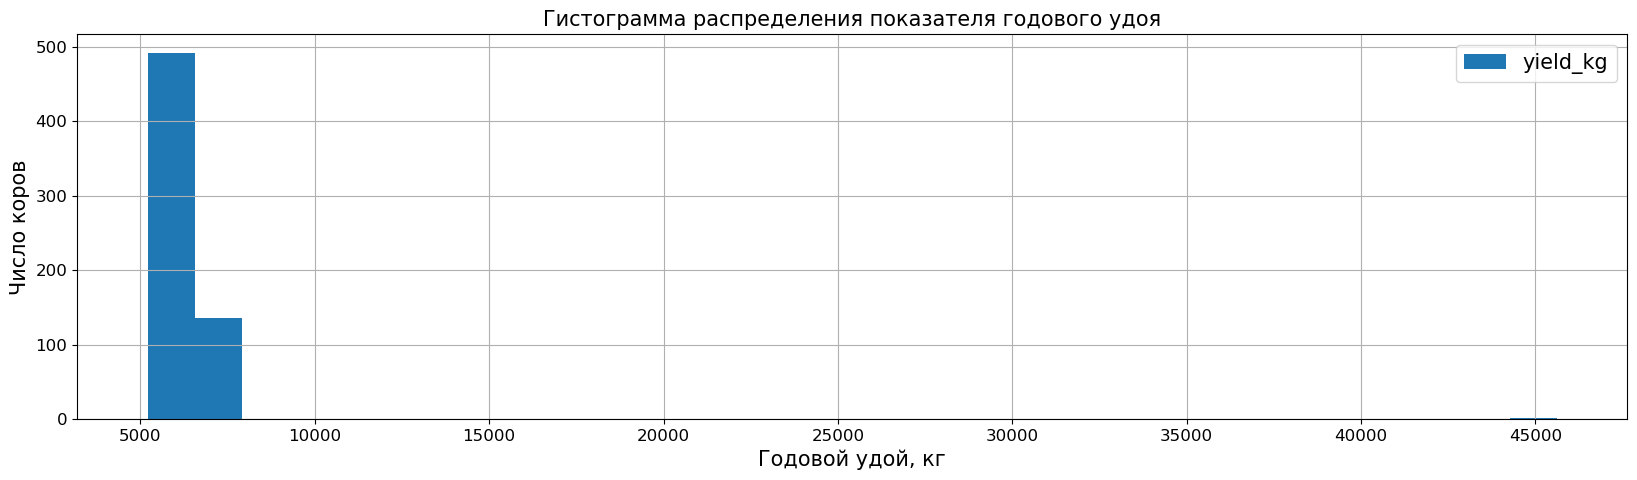

Статистика: count      629.000000
mean      6188.750397
std       1644.795489
min       5204.000000
25%       5751.000000
50%       6133.000000
75%       6501.000000
max      45616.000000
Name: yield_kg, dtype: float64


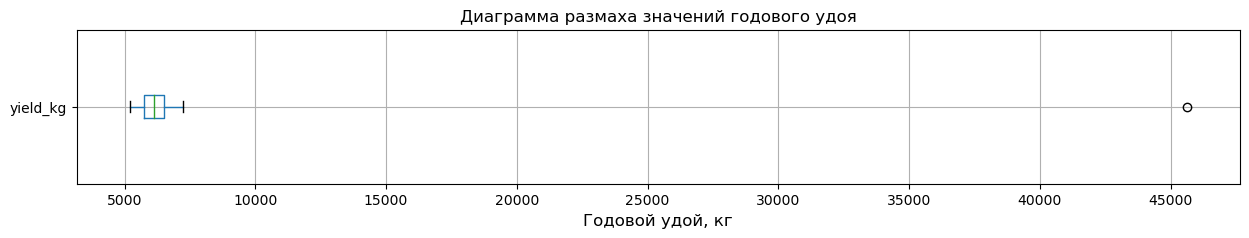

In [23]:
ferma_main['yield_kg'].plot(kind = 'hist', bins = 30, figsize = (20, 5), grid = True, legend = True)
plt.title('Гистограмма распределения показателя годового удоя', fontsize=15)
plt.xlabel('Годовой удой, кг', fontsize = 15)
plt.ylabel('Число коров', fontsize = 15)
plt.legend(fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

fig, ax = plt.subplots(figsize = (15,2))
ax = ferma_main[['yield_kg']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений годового удоя')
ax.set_xlabel('Годовой удой, кг', fontsize = 12)

;

print('Статистика:', ferma_main['yield_kg'].describe())

Видим явную аномалию с годовым удоем 45616 кг. Посмотрим 0.99 процентиль и сколько строк выходит за его пределы.

In [24]:
ferma_main['yield_kg'].quantile([0.99])

0.99    7164.04
Name: yield_kg, dtype: float64

Посмотрим строки, в которых значение годового удоя выше 0.99 процентиля.

In [25]:
ferma_main[ferma_main['yield_kg']>7200]

index   id  yield_kg   eke  raw_protein  sugar_prot_rate  \
16      16   17     45616  11.5         1675             0.93   
70      70   71      7222  16.8         2157             0.95   
135    135  136      7207  16.6         2343             0.94   
296    296  297      7201  15.8         2077             0.94   

               breed    pasture dad_breed  fat_%  protein_%   taste  \
16    Вис Бик Айдиал  Холмистое    Айдиал   3.22      3.076  вкусно   
70    Вис Бик Айдиал  Холмистое    Айдиал   3.70      3.076  вкусно   
135   Вис Бик Айдиал  Холмистое    Айдиал   3.72      3.078  вкусно   
296  РефлешнСоверинг  Холмистое    Айдиал   3.71      3.072  вкусно   

             age  
16   более_2_лет  
70   более_2_лет  
135  более_2_лет  
296  более_2_лет

Значения в пределах 7200 кг в год еще допустимы, а значение 45616 - это аномалия и, скорее всего, ошибка, а не опечатка: если значение удоя разделить на 10, то получим значение сильно ниже минимального, исправить на корректное в данном случае сложно. Просто удалим эту строку.

In [26]:
ferma_main = ferma_main[ferma_main['yield_kg']<7250]



Построим графики после обработки аномального значения.

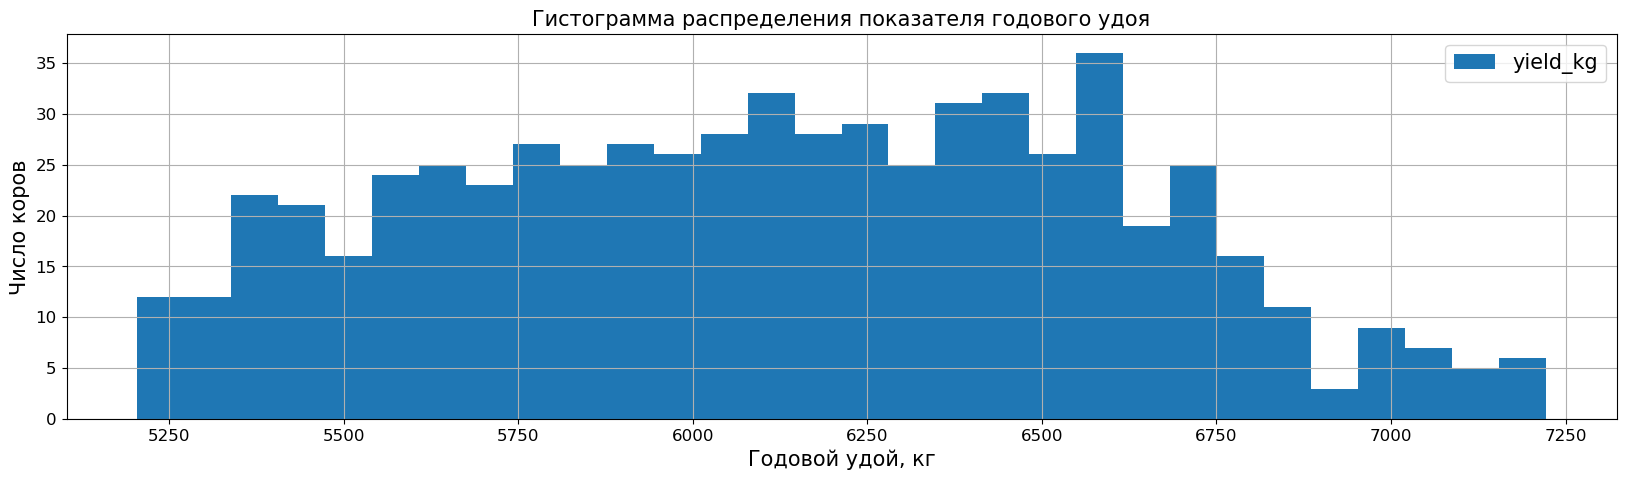

Статистика: count     628.000000
mean     6125.968153
std       475.857053
min      5204.000000
25%      5749.750000
50%      6132.500000
75%      6501.000000
max      7222.000000
Name: yield_kg, dtype: float64


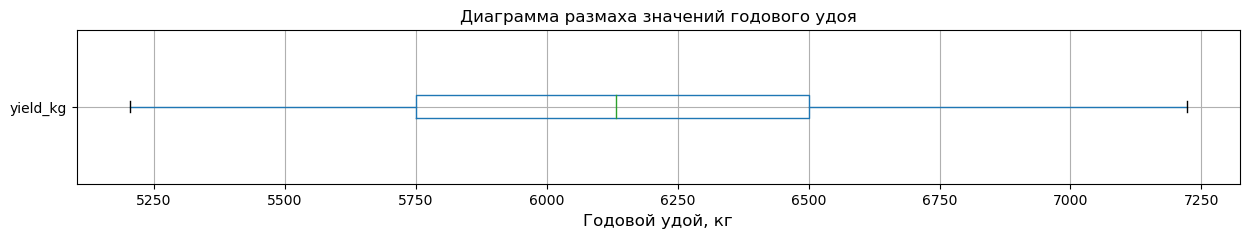

In [27]:
ferma_main['yield_kg'].plot(kind = 'hist', bins = 30, figsize = (20, 5), grid = True, legend = True)
plt.title('Гистограмма распределения показателя годового удоя', fontsize=15)
plt.xlabel('Годовой удой, кг', fontsize = 15)
plt.ylabel('Число коров', fontsize = 15)
plt.legend(fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

fig, ax = plt.subplots(figsize = (15,2))
ax = ferma_main[['yield_kg']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений годового удоя')
ax.set_xlabel('Годовой удой, кг', fontsize = 12)
;

print('Статистика:', ferma_main['yield_kg'].describe())


Среднее значение годового удоя почти совпадает с медианой и равно 6 125 кг в год. Половина значений лежит в интервале от 5,2 тыс. кг в год до 6,5 тыс. кг в год, минимальное и максимальное значения - 5,2 тыс. кг и 7,2 тыс. кг в год. Разброс значений не очень выоский - 475 кг.

***EKE (энергетическая кормовая единица)***

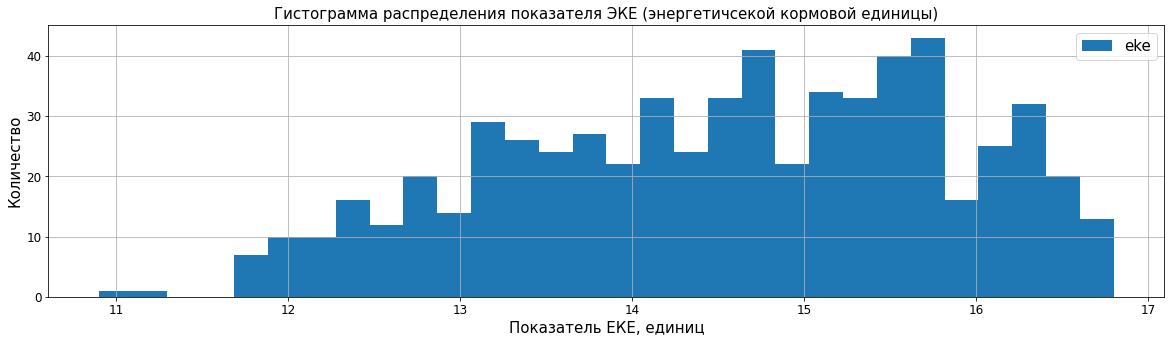

Статистика: count    628.000000
mean      14.548726
std        1.301777
min       10.900000
25%       13.500000
50%       14.700000
75%       15.600000
max       16.800000
Name: eke, dtype: float64


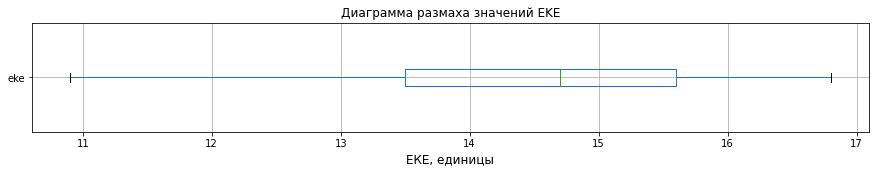

In [37]:
ferma_main['eke'].plot(kind = 'hist', bins = 30, figsize = (20, 5), grid = True, legend = True)
plt.title('Гистограмма распределения показателя ЭКЕ (энергетичсекой кормовой единицы)', fontsize=15)
plt.ylabel('Количество', fontsize=15)
plt.xlabel('Показатель ЕКЕ, единиц', fontsize=15)
plt.legend(fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

fig, ax = plt.subplots(figsize = (15,2))
ax = ferma_main[['eke']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений EKE')
ax.set_xlabel('ЕКЕ, единицы', fontsize = 12)
;

print('Статистика:', ferma_main['eke'].describe())

Распределение данных по показателю ЕКЕ не равномерное, медианное значение - 14,7, минимальное и максимальное значения - 10,9 и 16,8 соответственно, дисперсия не высокая, выбросов и аномалий нет.

***Raw_protein (сырой протеин)***

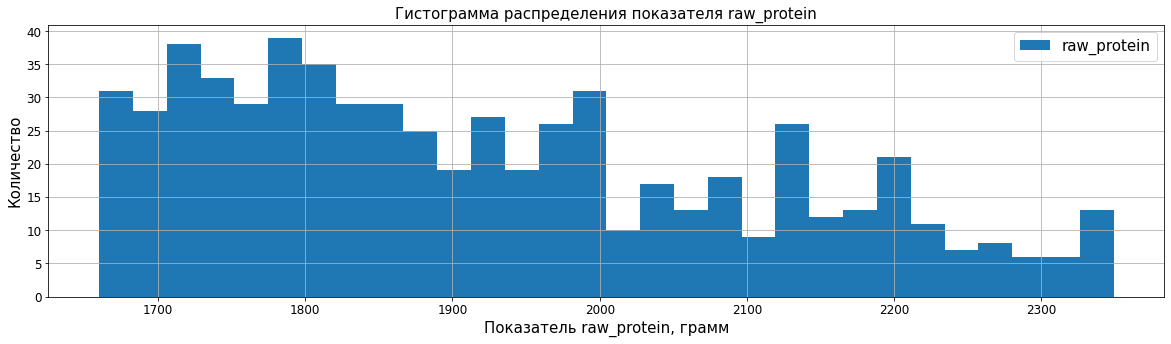

Статистика: count     628.000000
mean     1923.759554
std       182.832816
min      1660.000000
25%      1771.750000
50%      1888.000000
75%      2062.250000
max      2349.000000
Name: raw_protein, dtype: float64


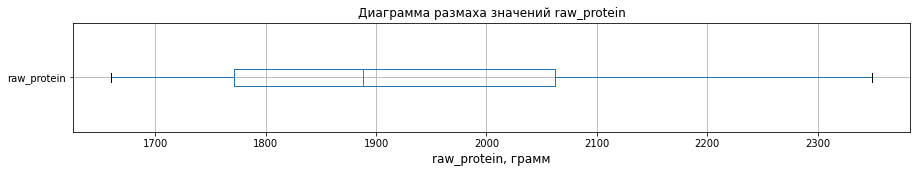

In [38]:
ferma_main['raw_protein'].plot(kind = 'hist', bins = 30, figsize = (20, 5), grid = True, legend = True)
plt.title('Гистограмма распределения показателя raw_protein', fontsize=15)
plt.ylabel('Количество', fontsize=15)
plt.xlabel('Показатель raw_protein, грамм', fontsize=15)
plt.legend(fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

fig, ax = plt.subplots(figsize = (15,2))
ax = ferma_main[['raw_protein']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений raw_protein')
ax.set_xlabel('raw_protein, грамм', fontsize = 12)
;

print('Статистика:', ferma_main['raw_protein'].describe())

Распределение данных по показателю raw_protein не равномерно, чаще всего встречаются значения от 1600 до 2000 грамм, медианное значение - 1888 г, минимальное и максимальное значения - 1660 г и 2349 г соответственно, дисперсия не высокая, выбросов и аномалий нет.

***Sugar_prot_rate (сахаро-протеиновое соотношение)***

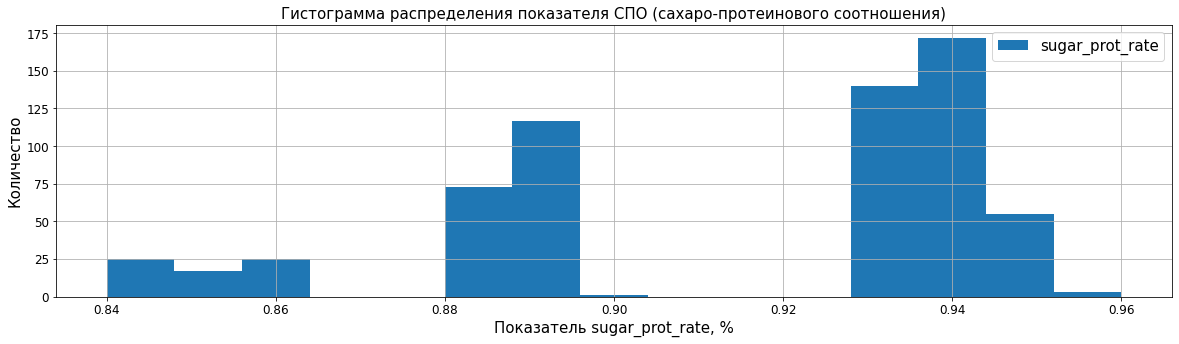

Статистика: count    628.000000
mean       0.913089
std        0.032221
min        0.840000
25%        0.890000
50%        0.930000
75%        0.940000
max        0.960000
Name: sugar_prot_rate, dtype: float64


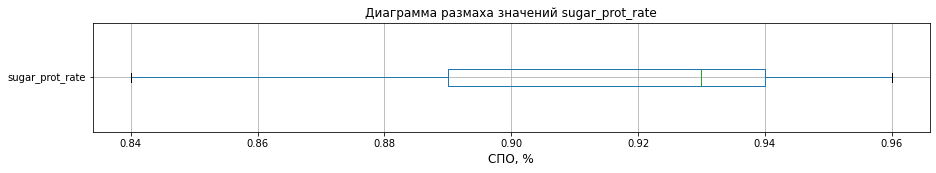

In [39]:
ferma_main['sugar_prot_rate'].plot(kind = 'hist', bins = 15, figsize = (20, 5), grid = True, legend = True)
plt.title('Гистограмма распределения показателя СПО (сахаро-протеинового соотношения)', fontsize=15)
plt.ylabel('Количество', fontsize=15)
plt.xlabel('Показатель sugar_prot_rate, %', fontsize=15)
plt.legend(fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

fig, ax = plt.subplots(figsize = (15,2))
ax = ferma_main[['sugar_prot_rate']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений sugar_prot_rate')
ax.set_xlabel('СПО, %', fontsize = 12)
;

print('Статистика:', ferma_main['sugar_prot_rate'].describe())

Видим, что есть 8 пиков и соответственно 8 основных значений соотношений сахар/протеин, самые популярные значения - 0.93, 0.94 соответствуют самым высоким пикам на гистограмме. Выбросов и аномалий нет. 

***Fat_% (процент жирности)***

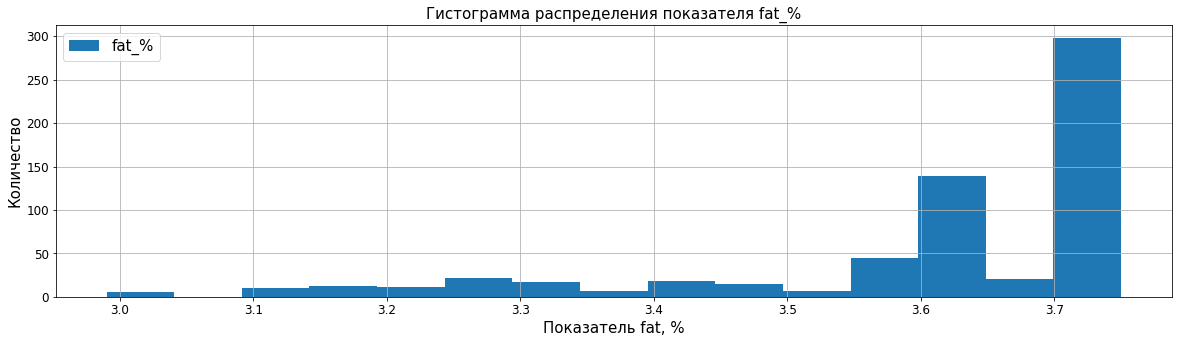

Статистика: count    628.000000
mean       3.604268
std        0.168093
min        2.990000
25%        3.590000
50%        3.650000
75%        3.720000
max        3.750000
Name: fat_%, dtype: float64


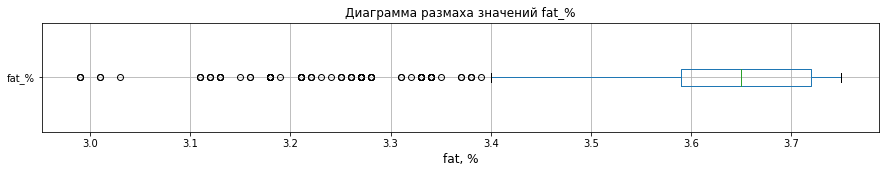

In [40]:
ferma_main['fat_%'].plot(kind = 'hist', bins = 15, figsize = (20, 5), grid = True, legend = True)
plt.title('Гистограмма распределения показателя fat_%', fontsize=15)
plt.ylabel('Количество', fontsize=15)
plt.xlabel('Показатель fat, %', fontsize=15)
plt.legend(fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

fig, ax = plt.subplots(figsize = (15,2))
ax = ferma_main[['fat_%']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений fat_%')
ax.set_xlabel('fat, %', fontsize = 12)
;


print('Статистика:', ferma_main['fat_%'].describe())

На гистограмме видим, что больше всего коров (около 300, почти половина) имеют показатель жирности примерно 3,7%. судя по стаитистике, крайне редко втсречаются показатели ниже 3,1%. Судя по распределению значений, этот признак можно перевести в категориальный, тк подавляющая часть коров имеет показатели жирности 3,6-3,7%.

Посмотрим, сколько строк имеют крайне низкий показетль fat_%.

In [41]:
display(ferma_main[ferma_main['fat_%']<3.1])

index   id  yield_kg   eke  raw_protein  sugar_prot_rate  \
17      17   18      5777  12.4         1873            0.895   
554    554  555      5686  14.7         1712            0.860   
558    558  559      5346  12.4         1837            0.860   
561    561  562      5300  13.0         1785            0.860   
568    568  569      5989  13.2         1721            0.860   
576    576  577      5376  11.7         1825            0.860   

               breed    pasture dad_breed  fat_%  protein_%      taste  \
17    Вис Бик Айдиал  Холмистое    Айдиал   3.03      3.080     вкусно   
554  РефлешнСоверинг  Холмистое    Айдиал   3.01      3.074     вкусно   
558  РефлешнСоверинг  Холмистое   Соверин   3.01      3.078  не вкусно   
561   Вис Бик Айдиал  Равнинное   Соверин   2.99      3.077  не вкусно   
568   Вис Бик Айдиал  Холмистое   Соверин   2.99      3.076     вкусно   
576  РефлешнСоверинг  Равнинное   Соверин   2.99      3.076  не вкусно   

             age  
17   более_2_лет  
554  более_2_лет  
558  менее_2_лет  
561  менее_2_лет  
568  менее_2_лет  
576  менее_2_лет

Несколько значений, сильно выбивающихся из общей картины (менее 3,1%), удалять не нужно, т к это явно не аномалии, таких строк всего 6, и их на личие не сильно скажется на расчете корреляции между входным и целевым признаками и на качестве прогноза.

***Protein_% (белок)***

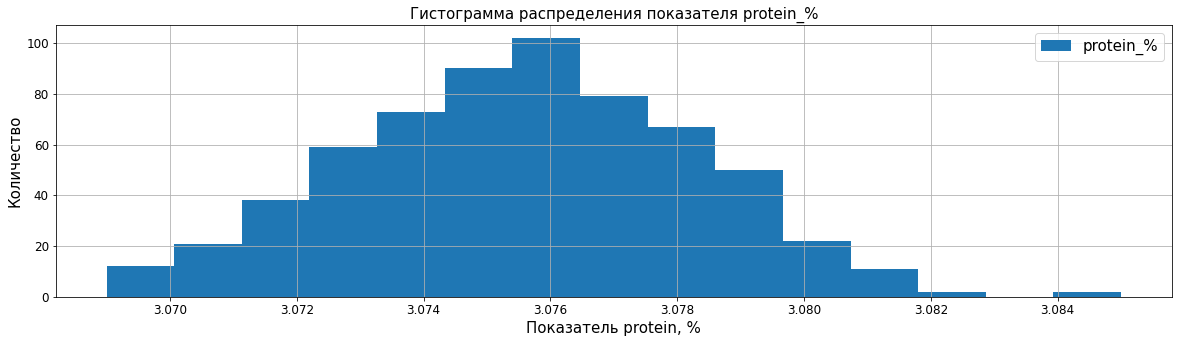

Статистика: count    628.000000
mean       3.075670
std        0.002551
min        3.069000
25%        3.074000
50%        3.076000
75%        3.077000
max        3.085000
Name: protein_%, dtype: float64


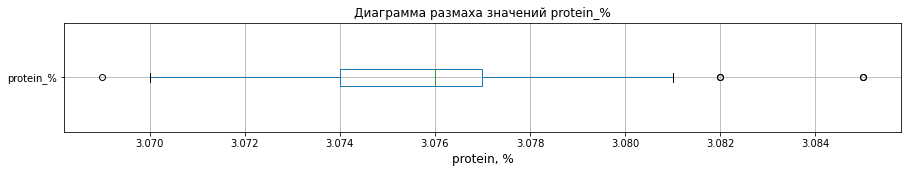

In [42]:
ferma_main['protein_%'].plot(kind = 'hist', bins = 15, figsize = (20, 5), grid = True, legend = True)
plt.title('Гистограмма распределения показателя protein_%', fontsize=15)
plt.ylabel('Количество', fontsize=15)
plt.xlabel('Показатель protein, %', fontsize=15)
plt.legend(fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

fig, ax = plt.subplots(figsize = (15,2))
ax = ferma_main[['protein_%']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений protein_%')
ax.set_xlabel('protein, %', fontsize = 12)
;

print('Статистика:', ferma_main['protein_%'].describe())

Среднее значение равно медиане 3,07%, дисперсия низкая, выбросов нет.

Перейдем к анализу ***качественных показателей***: порода, тип пастбища, порода папы, вкус, возраст.

***Порода***

In [28]:
ferma_main['breed'].value_counts()

breed
Вис Бик Айдиал     372
РефлешнСоверинг    256
Name: count, dtype: int64

Для бинарных признаков подойдет круговая диаграмма.

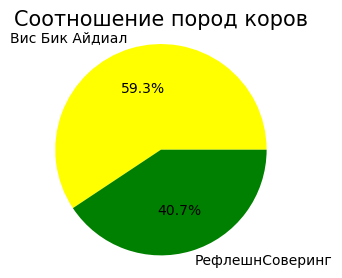

In [181]:
labels = ['Вис Бик Айдиал','РефлешнСоверинг']
values = [369,253]
colors = ['yellow','green']
fig = plt.figure(1, figsize=(3,3))
plt.pie(values,labels=labels, colors=colors,  autopct='%.1f%%')
plt.title('Соотношение пород коров', fontsize=15)
plt.axis('equal')
plt.show();




59% пород - "Вис Бик Айдиал", 41% - "РефлешнСоверинг".

In [45]:
ferma_main['pasture'].value_counts()

pasture
Холмистое    350
Равнинное    278
Name: count, dtype: int64

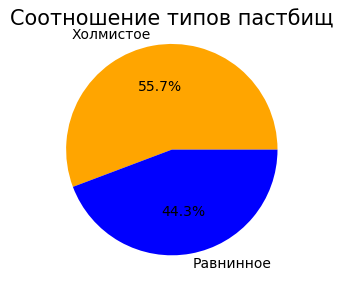

In [180]:
labels = ['Холмистое','Равнинное']
values = [350,278]
colors = ['orange','blue']
fig = plt.figure(1, figsize=(3,3))
plt.pie(values,labels=labels, colors=colors, autopct='%.1f%%')
plt.title('Соотношение типов пастбищ', fontsize=15)
plt.axis('equal')
plt.show();

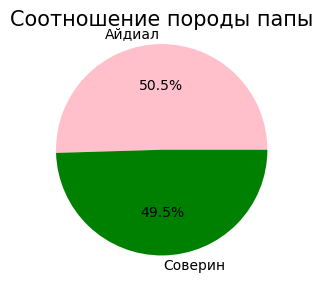

In [179]:
labels = ['Айдиал','Соверин']
values = [317, 311]
colors = ['pink','green']
fig = plt.figure(1, figsize=(3,3))
plt.pie(values,labels=labels, colors=colors,  autopct='%.1f%%')
plt.title('Соотношение породы папы', fontsize=15)
plt.axis('equal')
plt.show();

In [51]:
ferma_main['taste'].value_counts()

taste
вкусно       370
не вкусно    258
Name: count, dtype: int64

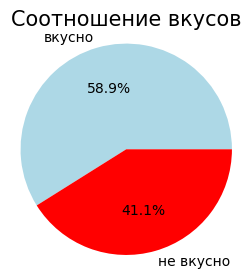

In [182]:
labels = ['вкусно','не вкусно']
values = [370, 258]
colors = ['lightblue','red']
fig = plt.figure(1, figsize=(3,3))
plt.pie(values,labels=labels, colors=colors,  autopct='%.1f%%')
plt.title('Соотношение вкусов', fontsize=15)
plt.axis('equal')
plt.show();

In [55]:
ferma_main['age'].value_counts()

age
более_2_лет    518
менее_2_лет    110
Name: count, dtype: int64

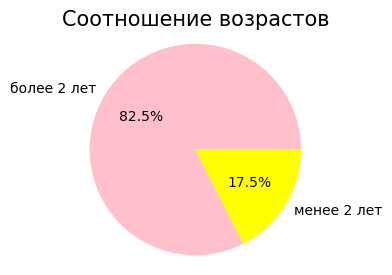

In [183]:
labels = ['более 2 лет','менее 2 лет']
values = [518, 110]
colors = ['pink','yellow']
fig = plt.figure(1, figsize=(3,3))
plt.pie(values,labels=labels, colors=colors,  autopct='%.1f%%')
plt.title('Соотношение возрастов', fontsize=15)
plt.axis('equal')
plt.show();

Проанализируем данные в таблице 'cow_buy'. Начнем с категориальных признаков: breed, pasture, dad_breed, dad_name, age.         

In [63]:
list_of_cat_values = ['breed', 'pasture', 'dad_breed', 'dad_name', 'age']
for value in list_of_cat_values:
    print('value', '\n', cow_buy[value].value_counts(), '\n')
#cow_buy['breed'].value_counts()

value 
 breed
РефлешнСоверинг    11
Вис Бик Айдиал      9
Name: count, dtype: int64 

value 
 pasture
Равнинное    11
Холмистое     9
Name: count, dtype: int64 

value 
 dad_breed
Соверин    12
Айдиал      8
Name: count, dtype: int64 

value 
 dad_name
Буйный      8
Геркулес    6
Барин       4
Соловчик    2
Name: count, dtype: int64 

value 
 age
более_2_лет    15
менее_2_лет     5
Name: count, dtype: int64 



Посмотрим количественные признаки: current_fat_%, current_protein_%.

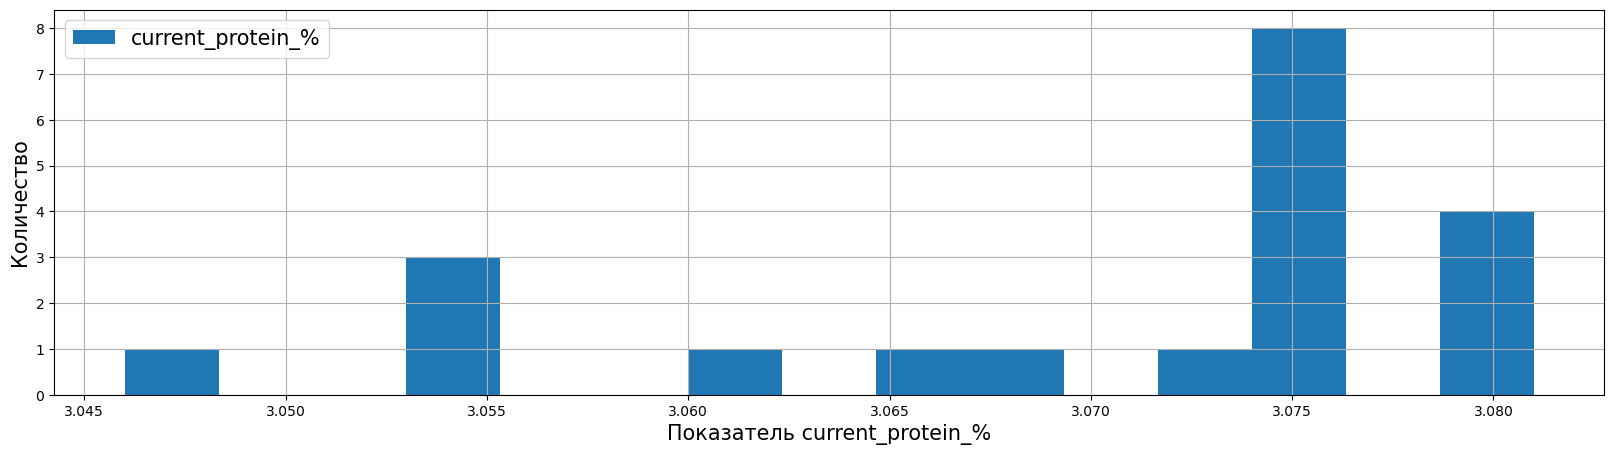

Статистика: count    20.000000
mean      3.069500
std       0.010339
min       3.046000
25%       3.064000
50%       3.074000
75%       3.076000
max       3.081000
Name: current_protein_%, dtype: float64


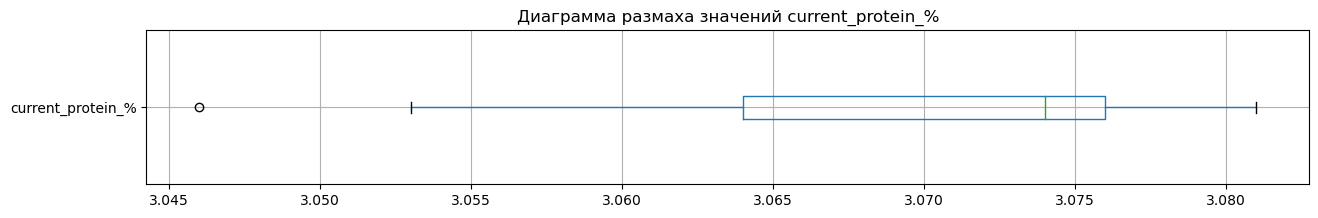

In [64]:
cow_buy['current_protein_%'].plot(kind = 'hist', bins = 15, figsize = (20, 5), grid = True, legend = True)
plt.ylabel('Количество', fontsize=15)
plt.xlabel('Показатель current_protein_%', fontsize=15)
plt.legend(fontsize = 15)
plt.show()

fig, ax = plt.subplots(figsize = (15,2))
ax = cow_buy[['current_protein_%']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений current_protein_%')
;

print('Статистика:', cow_buy['current_protein_%'].describe())

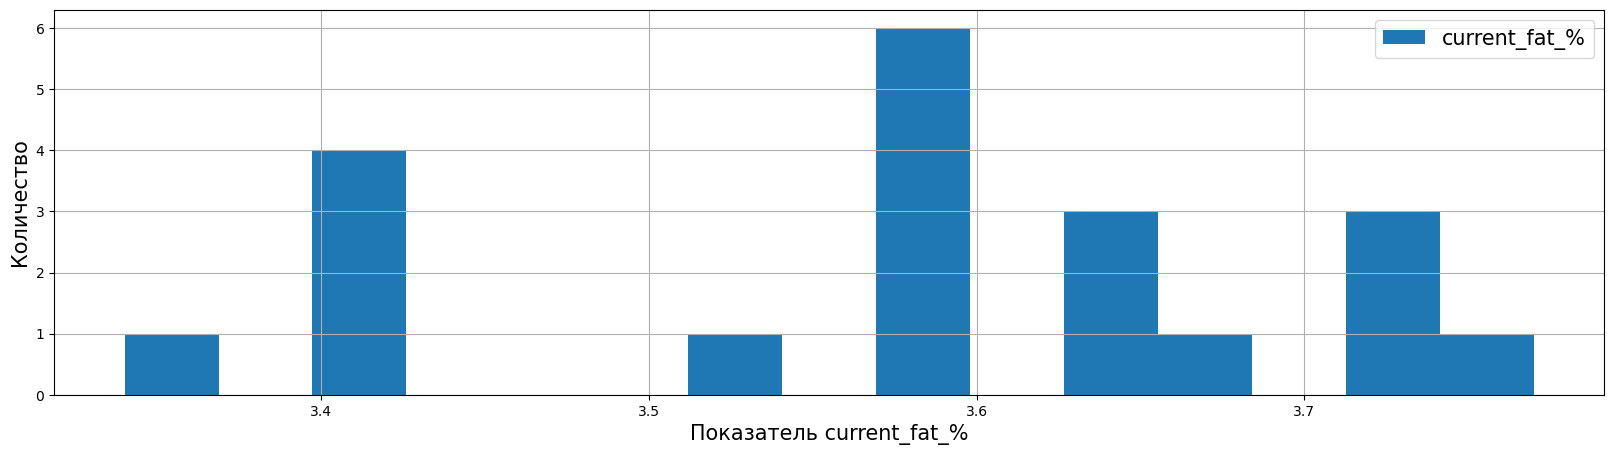

Статистика: count    20.000000
mean      3.577500
std       0.126818
min       3.340000
25%       3.510000
50%       3.590000
75%       3.650000
max       3.770000
Name: current_fat_%, dtype: float64


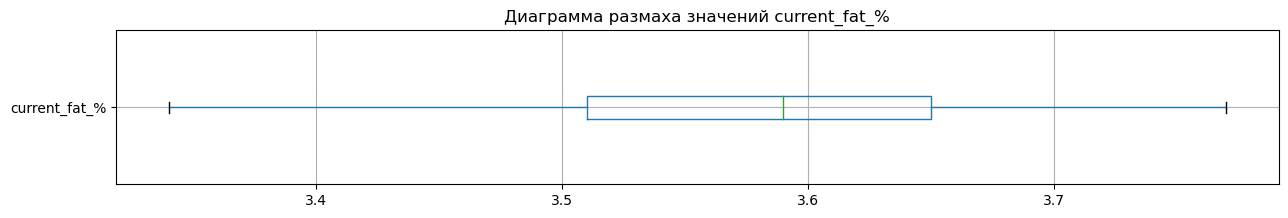

In [65]:
cow_buy['current_fat_%'].plot(kind = 'hist', bins = 15, figsize = (20, 5), grid = True, legend = True)
plt.ylabel('Количество', fontsize=15)
plt.xlabel('Показатель current_fat_%', fontsize=15)
plt.legend(fontsize = 15)
plt.show()

fig, ax = plt.subplots(figsize = (15,2))
ax = cow_buy[['current_fat_%']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений current_fat_%')
;

print('Статистика:', cow_buy['current_fat_%'].describe())

Никаких странностей в количественных данных в таблице cow_buy нет, значения нормальрные, дисперсия низкая.

Посмотрим уникальные значения таблицы ferma_dad.

In [66]:
ferma_dad['dad_name'].value_counts()

dad_name
Барин       240
Буйный      215
Соловчик    110
Геркулес     64
Name: count, dtype: int64

***Выводы по итогам исследовательского анализа данных:***

***1)*** Избавились от аномалии в показателе годового удоя. Среднее значение годового удоя равно 6 125 кг в год. Половина значений лежит в интервале от 5,2 тыс. кг в год до 6,5 тыс. кг в год, разброс значений не очень выоский - 475 кг.

***2)*** Распределение данных по показателям ЕКЕ, raw_protein, protein_% близки к нормальному, дисперсии не высокие, выбросов и аномалий нет.

***3)*** У показателя Сахаро-протеинового соотношения есть 8 пиков и соответственно 8 основных значений, самые популярные значения - 0.93, 0.94 соответствуют самым высоким пикам на гистограмме. Выбросов и аномалий нет. Больше всего коров (около 300, почти половина) имеют показатель жирности примерно 3,7%. 

***4)*** Почти все категориальные признаки, кроме age, распределены в отношении примерно (40/60 - 50/50), взрослых коров (возрастом более 2 лет) в поголовье 82,5%.

***5)*** В выборке коров на продажу (cow_buy) всего 20 строк, и данные, кроме возраста, распределены по бинарным признакам (порода, порода папы, тип пастбища) в соотношениях 40/60, 50/50. Коров возраста более 2 лет 75% (15 коров).

## Корреляционный анализ

Рассчитаем коэффициенты корреляции между количественными признаками в ferma_main. Будем использовать коэфициенты корреляции  Спирмена т к характер зависимости судя по диаграммам рассеяния ниже больше похож на монотонный. Есть тренд роста целевого признака при увеличении входных.

Сделаем отдельный датафрейм с количественными признаками:

In [67]:
ferma_main_col = ferma_main[['yield_kg', 'eke', 'raw_protein','sugar_prot_rate', 'fat_%', 'protein_%']]
print(ferma_main_col.corr(method = 'spearman'))

                 yield_kg       eke  raw_protein  sugar_prot_rate     fat_%  \
yield_kg         1.000000  0.765144     0.437543         0.787904  0.688506   
eke              0.765144  1.000000     0.384747         0.741962  0.686973   
raw_protein      0.437543  0.384747     1.000000         0.485890  0.392822   
sugar_prot_rate  0.787904  0.741962     0.485890         1.000000  0.701044   
fat_%            0.688506  0.686973     0.392822         0.701044  1.000000   
protein_%       -0.005701 -0.013321     0.229051         0.109924  0.043125   

                 protein_%  
yield_kg         -0.005701  
eke              -0.013321  
raw_protein       0.229051  
sugar_prot_rate   0.109924  
fat_%             0.043125  
protein_%         1.000000  


Для наглядности построим тепловую карту коэффициентов корреляции между количественными признаками.

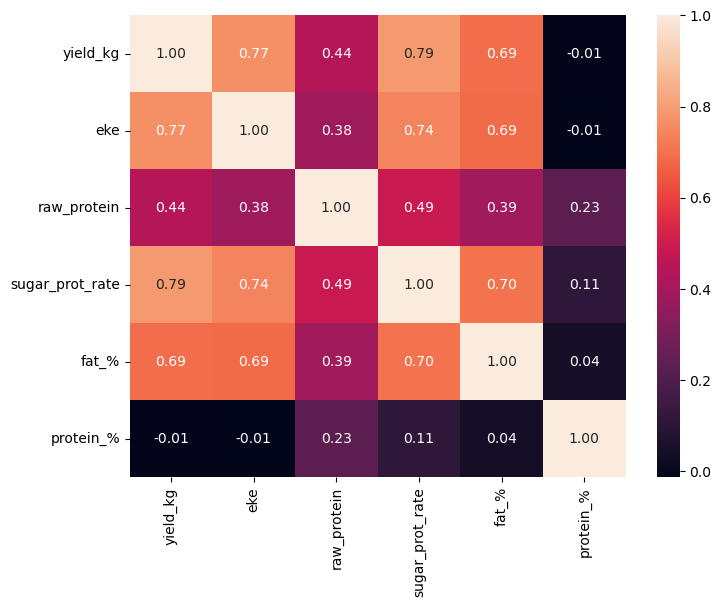

In [70]:
plt.figure(figsize = (8,6))
sns.heatmap(ferma_main_col.corr(method = 'spearman'), annot=True, fmt='.2f'); 

Высокая корреляция с показателем 'yield_kg' (годовой удой) наблюдается у показателей sugar_prot_rate - 79% и eke - 77%. Заметная корреляция   у показетеля fat_% с признаками yield_kg (69%), eke (69%), sugar_prot_rate (70%).
У показателя protein_% отсутствует корреляция со всеми признаками, кроме raw_protein (23%).


Зависимость между входными признаками не критичная для того, чтобы ухудшить качество работы модели, поэтому удалять входные признаки не стОит.


Для определения зависимости между количественными и категориальными признаками используем коэффициент корреляции Фи.

In [71]:
ferma_main_phik = ferma_main[['yield_kg', 'eke', 'raw_protein', 'sugar_prot_rate', 'breed', 'pasture',
                              'dad_breed', 'fat_%', 'protein_%', 'taste', 'age']]
corr_matrix_ferma_main = ferma_main_phik.phik_matrix(interval_cols = ['yield_kg', 'eke', 'raw_protein',
                                                                      'sugar_prot_rate', 'fat_%', 'protein_%'],
                                                    bins = {'yield_kg':10, 'eke':10, 'raw_protein':8, 
                                                           'sugar_prot_rate':3, 'fat_%':2, 'protein_%':8}) 
display(corr_matrix_ferma_main)

yield_kg       eke  raw_protein  sugar_prot_rate     breed  \
yield_kg         1.000000  0.720719     0.369409         0.814043  0.164744   
eke              0.720719  1.000000     0.358403         0.699227  0.123086   
raw_protein      0.369409  0.358403     1.000000         0.412824  0.000000   
sugar_prot_rate  0.814043  0.699227     0.412824         1.000000  0.033014   
breed            0.164744  0.123086     0.000000         0.033014  1.000000   
pasture          0.279540  0.106758     0.164909         0.065367  0.213218   
dad_breed        0.519915  0.171355     0.000000         0.163300  0.089330   
fat_%            0.602707  0.635098     0.348549         0.237036  0.000000   
protein_%        0.017751  0.000000     0.258647         0.059405  0.363686   
taste            0.173122  0.272265     0.169134         0.098860  0.000000   
age              0.998101  0.771596     0.370876         0.356789  0.057295   

                  pasture  dad_breed     fat_%  protein_%     taste       age  
yield_kg         0.279540   0.519915  0.602707   0.017751  0.173122  0.998101  
eke              0.106758   0.171355  0.635098   0.000000  0.272265  0.771596  
raw_protein      0.164909   0.000000  0.348549   0.258647  0.169134  0.370876  
sugar_prot_rate  0.065367   0.163300  0.237036   0.059405  0.098860  0.356789  
breed            0.213218   0.089330  0.000000   0.363686  0.000000  0.057295  
pasture          1.000000   0.000000  0.000000   0.101785  0.269063  0.128455  
dad_breed        0.000000   1.000000  0.000000   0.114635  0.000000  0.355817  
fat_%            0.000000   0.000000  1.000000   0.000000  0.000000  0.596105  
protein_%        0.101785   0.114635  0.000000   1.000000  0.162965  0.000000  
taste            0.269063   0.000000  0.000000   0.162965  1.000000  0.165974  
age              0.128455   0.355817  0.596105   0.000000  0.165974  1.000000

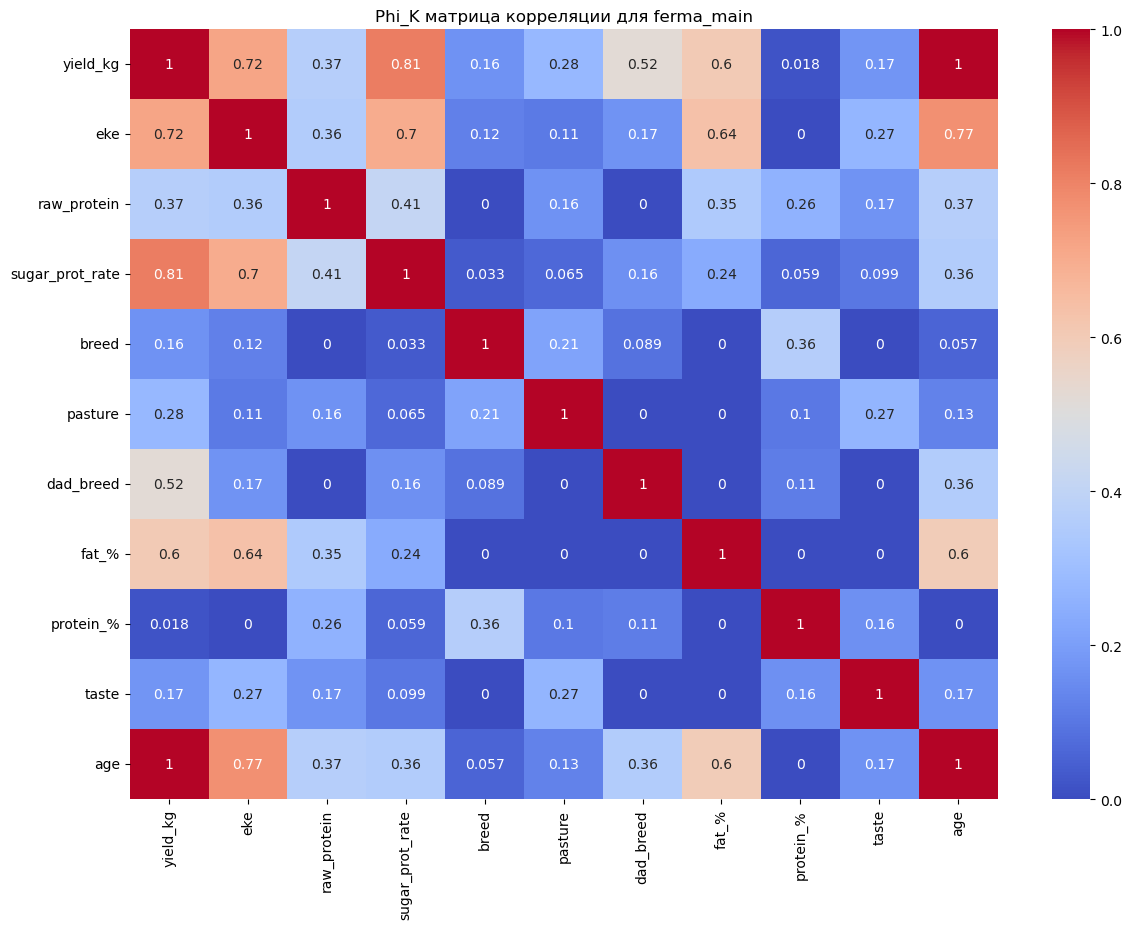

In [72]:
# Визуализация матрицы корреляции с использованием phik

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix_ferma_main, annot=True, cmap='coolwarm')
plt.title('Phi_K матрица корреляции для ferma_main')
plt.show()

После расчета коэффициентов корреляции Фи можно сделать выводы о связи количественных и категориальных признаков. Максимально высокая корреляция с целевым показателем у показателя возраста  - 100%, т е коровы старше 2 лет почти всегда дают бОльший годовой удой. У целевого признака наблюдается высокая корреляция с ЕКЕ (72%) и sugar_prot_rate (81%). Ощутимая корреляция у целевого показателя с породой папы (dad_breed) - 52%.

У входного признака age достаточно высокая корреляция с показателями EKE и fat_% сахаро-протеинового соотношения (72% и 81% соответственно). Заметная корреляция у возраста с показателем еке (77%).



Построим диаграммы рассеяния scatterplot для признака Удой, кг и всех количественных признаков с учётом значения категориальных признаков.

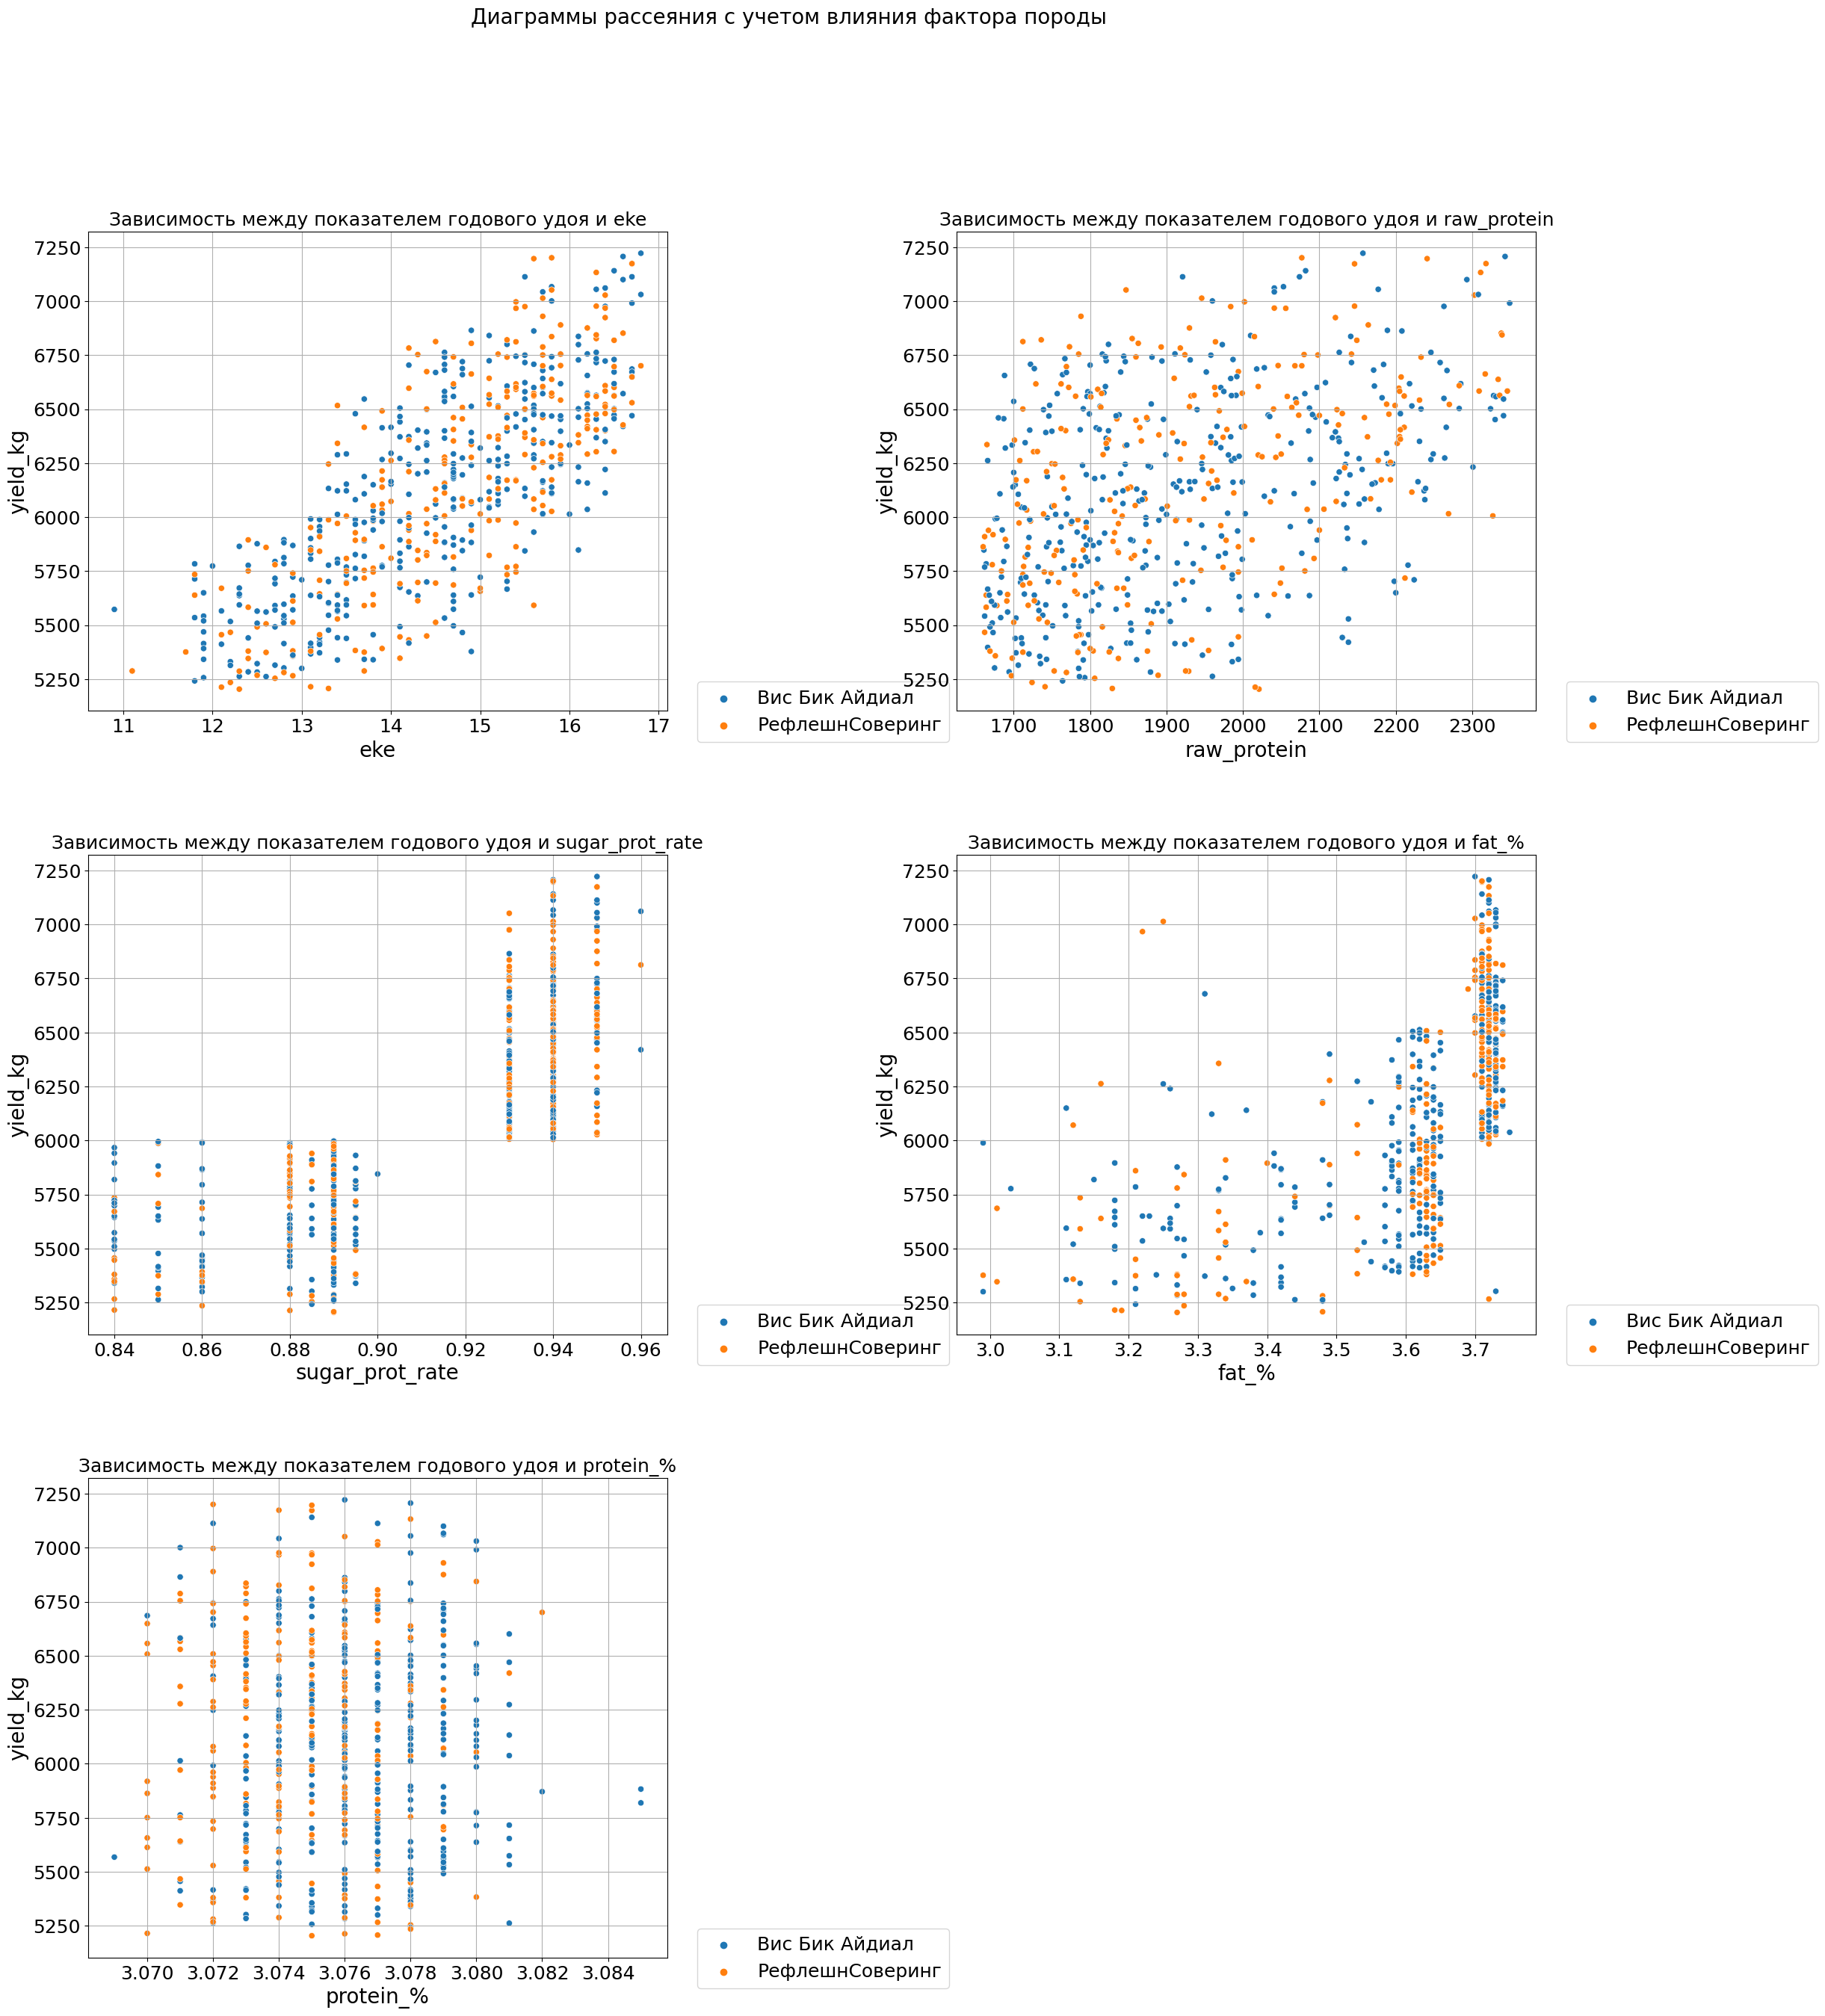

In [76]:
x_indicators = ['eke', 'raw_protein', 'sugar_prot_rate', 'fat_%', 'protein_%']
position = 0
plt.figure(figsize=[25,30])
plt.subplots_adjust(wspace=0.5, hspace=0.3)
plt.suptitle('Диаграммы рассеяния с учетом влияния фактора породы', fontsize=20)
for name in x_indicators:
    position += 1
    plt.subplot(3, 2, position)
    plt.title(f'Зависимость между показателем годового удоя и {name}', fontsize=18)
    sns.scatterplot(data = ferma_main, x = name, y='yield_kg', hue = 'breed')
    plt.xlabel(name, fontsize = 20)
    plt.ylabel('yield_kg', fontsize = 20)
    plt.legend(bbox_to_anchor=( 1.02 , 0.1 ), loc='upper left', borderaxespad= 1, fontsize = 18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.grid(True)
    

На точечной диаграмме, так же как на тепловой карте и матрице корреляций, видим зависимость между показателями eke (энергетическая кормовая единица) и годовым удоем. Зависимость не линейная, т к линия, вокруг которой сконцентрированы точки, кривая. Для усиления степени связи переведем признак ЕКЕ в квадратичный.

Точечная диаграмма, так же как тепловая карта и матрица корреляции, показывет отсутствие зависимости между показателями 'сырой протеин' и годовым удоем.

На точечной диаграмме видим, что определенным значениям показателя сахаро-протеинового соотношения соответствуют определенные интервалы значений годового удоя. В интервале sugar_prot_rate от 0.84 до 0.9 показатели годового удоя не выше 6000 кг. При значениях сахаро-протеинового соотношения 0.93-0.96 показатели годового удоя выше: от 6000 до 7250 кг.
 В связи с тем, что значение СПО 0,9 разбивает все значения целевого признака на 2 кластера, разумно будет перевести СПО в бинарный признак.

 На точечной диаграмме, отражающей зависимость между жирностью и годлвым удоем, видно, что для показателя жирности 3,6% значения годового удоя варьируется от 5300 до 6500 кг. Для показателя жирности 3,7% значения годового удоя варьируются от 6000 до 7250 кг.
 
 Для показателей жирности менее 3,6% явной зависимости или взаимосвязи с целевым показателем не наблюдается.
 
 Логично будет перевести признак fat_% в бинарный.

Линейной зависимости между показателем содержания белка и годового удоя нет.

На диаграммах рассеяния не видно влияния признака породы (pasture) на целевой показатель. При расчете коэффициентов Фи была зметна свзяь между показателем породы папы и годовым удоем. Посмотрим на диаграммах рассеяния влияние этого признака на целевой показатель.

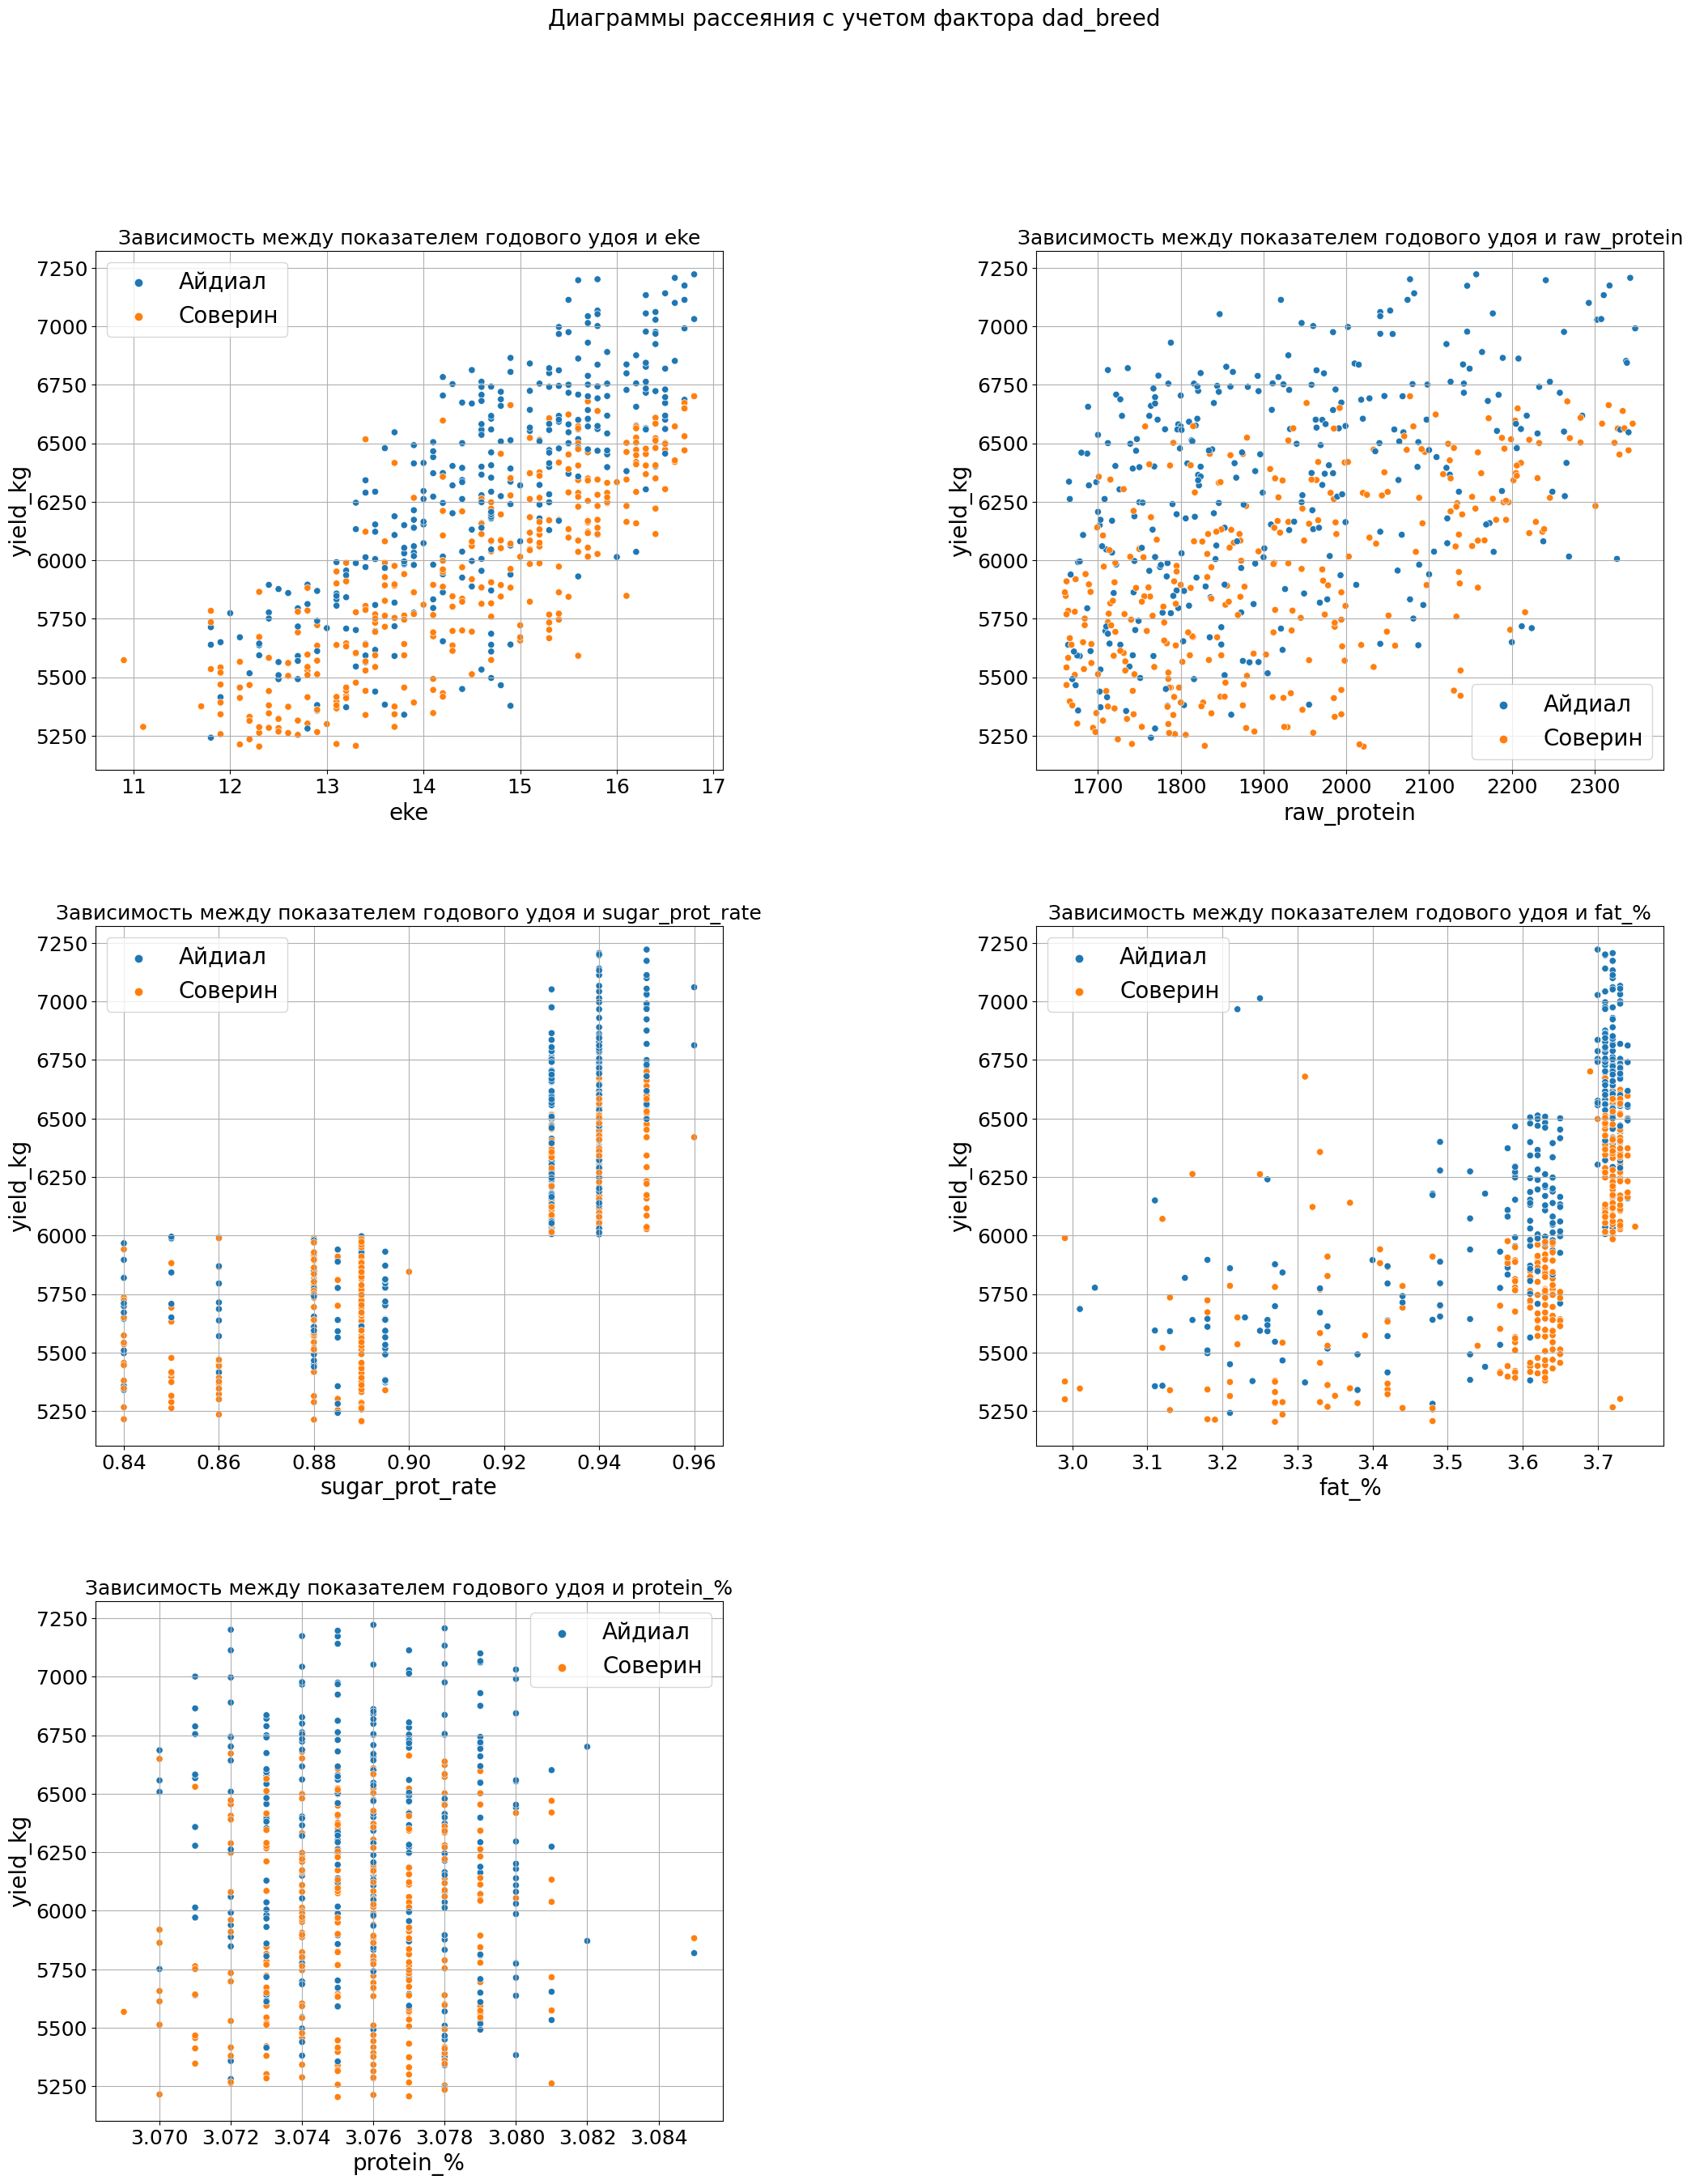

In [77]:
x_indicators = ['eke', 'raw_protein', 'sugar_prot_rate', 'fat_%', 'protein_%']
position = 0
plt.figure(figsize=[25,30])
plt.subplots_adjust(wspace=0.5, hspace=0.3)
plt.suptitle('Диаграммы рассеяния с учетом фактора dad_breed', fontsize=20)
for name in x_indicators:
    position += 1
    plt.subplot(3, 2, position)
    plt.title(f'Зависимость между показателем годового удоя и {name}', fontsize=18)
    sns.scatterplot(data = ferma_main, x = name, y='yield_kg', hue = 'dad_breed')
    plt.xlabel(name, fontsize = 20)
    plt.ylabel('yield_kg', fontsize = 20)
    plt.legend(fontsize = 20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.grid(True)

Видим, что порода папы влияет на удой ощутимо: на графиках видно, что удои коров с породой папы "Айдиал" выше, чем у коров с папой породы Соверин. При этом корреляции между породой самой коровы и годовым удоем не наблюдается.

Посмотрим влияние возраста коровы на целевой показатель, расчеты коэффициента корреляции Фи показали почти 100% зависимость между возрастом и удоем.

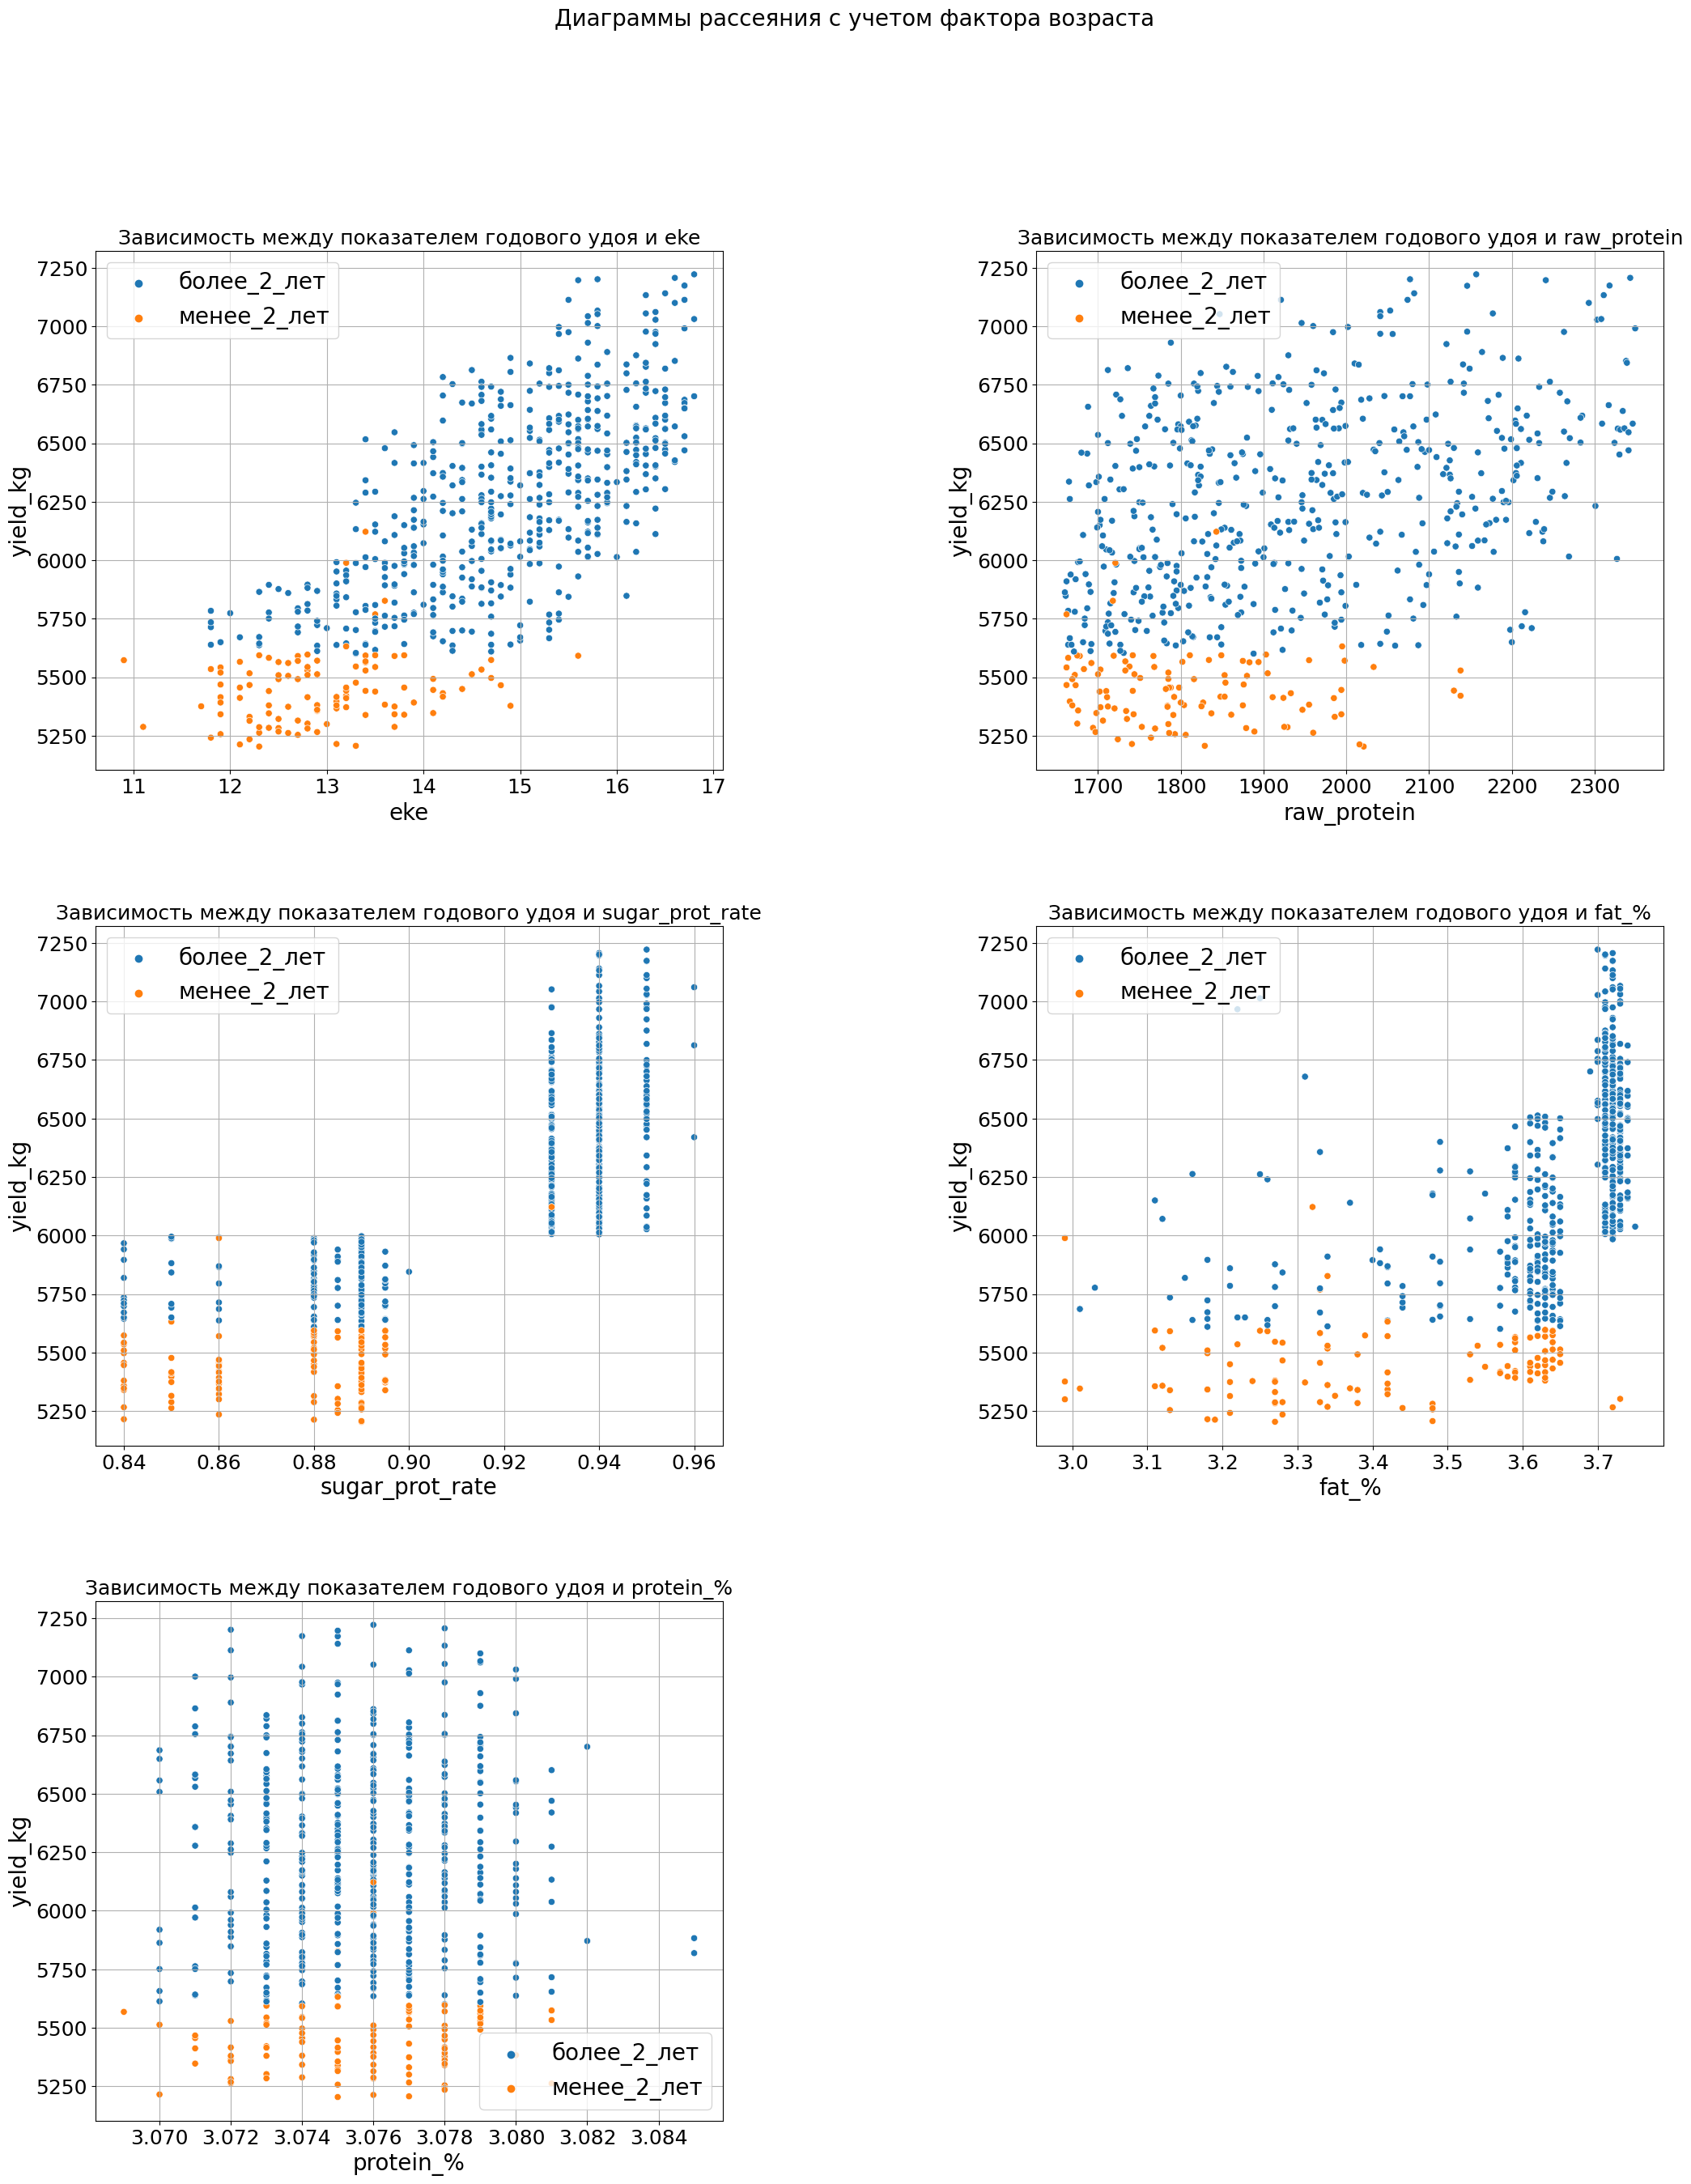

In [78]:
x_indicators = ['eke', 'raw_protein', 'sugar_prot_rate', 'fat_%', 'protein_%']
position = 0
plt.figure(figsize=[25,30])
plt.subplots_adjust(wspace=0.5, hspace=0.3)
plt.suptitle('Диаграммы рассеяния с учетом фактора возраста', fontsize=20)
for name in x_indicators:
    position += 1
    plt.subplot(3, 2, position)
    plt.title(f'Зависимость между показателем годового удоя и {name}', fontsize=18)
    sns.scatterplot(data = ferma_main, x = name, y='yield_kg', hue = 'age')
    plt.xlabel(name, fontsize = 20)
    plt.ylabel('yield_kg', fontsize = 20)
    plt.legend(fontsize = 20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.grid(True)

Очевидно, что от коров младше 2 лет урожая выше 5500-5600 кг в год ждать не стОит.

**Выводы по итогам корреляционного анализа:**

***1)*** Самая высокая корреляция с целевым признаком (годовой удой) наблюдается у показателей sugar_prot_rate - 81% и eke - 77%. По диаграммам рассеяния нельзя сказать, что связи линейные. В диаграмме рассеяния, отражающей зависимость между eke и удоем, точки сконцентрированы  вокруг кривой, больше напоминающей экспоненту. Чтобы усилить характер связи между целевым признаком и еке, можно возвести значения признака еке в квадрат и посмотреть изменение характера связи.

Связь между удоем и СПО (sugar_prot_rate) не линейная: при значении СПО менее 0.9 значения целевого признака менее 6000 кг, при значении СПО более 0.9 показатели удоя выше 6000 кг. Чтобы усилить влияние СПО, нужно перевести его в бинарный признак.

***2)*** Порода коровы никак не влияет на показатели удоя, в то время как связь между породой папы коровы и удоем на диаграммах рассеяния очевидна: коровы от пап породы Айдиал дают ощутимо больший удой. 

***3)*** Коровы возраста младше 2 лет в среднем дают 5200-5600 кг в год, бОльшие удои характерны для коров старше 2 лет.

***4)*** Между показателем жирности молока и удоем на диаграммах рассеяния тоже видна связь: при показателях ниже ~3,68% годовые удои  почти не превышают значения 6500, при показателе выше 3,68% значения удоев почти всегда больше 6000 кг и достигают максимума 7250 кг в год. Показатель жирности имеет смысл перевести в бинарный признак, т к при одном из значений (более 3,68%) показатели удоя четко соответсвуют одному из критериев для покупки ( годовой удой более 6000 кг).

***5)*** Видна связь между входными признаками sugar_prot_rate и eke: коэффициент корреляции между ними составляет 75%. Линейные связи между другими входными признаками выражены намного слабее. Можно сказать, что линейные связи между входными признаками не настолько сильные, чтобы ухудшить качество работы модели. 

***6)*** Максимально высокая нелинейная корреляция с целевым показателем у показателя возраста  - 100%, т е коровы старше 2 лет всегда дают бОльший годовой удой, нелинейные связи с другими входными признаками выражены слабее. 

Высокая корреляция у входного признака age с показателями EKE (77%). Ощутимая корреляция между породой папы (dad_breed) и целевым показателем удоя - 52%. 



## Обучение модели линейной регрессии

**Первая модель**

Разделим признаки на входные и целевые.

Разделим признаки на категориальные и количественные, отмасштабируем количественные и закодируем категориальные.

In [81]:
# сохранение входных признаков в переменную X
X = ferma_main.drop('yield_kg', axis = 1)


# сохранение целевого признака в переменную y
y = ferma_main['yield_kg']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE)

cat_col_names = ['breed', 'pasture', 'dad_breed', 'taste', 'age']
num_col_names = ['eke', 'raw_protein', 'sugar_prot_rate', 'fat_%']

# создадим переменную с экземпляром класса StandardScaler()
scaler = StandardScaler()

# обучим и трансформируем количественные признаки из тренировочной выборки 
X_train_scaled = scaler.fit_transform(X_train[num_col_names])

# выполним преобразование количественных признаков в тестовой выборке
X_test_scaled = scaler.transform(X_test[num_col_names])

# создадим переменную с экземпляром класса OneHotEncoder()
encoder = OneHotEncoder(drop = 'first', sparse_output = False)
#df = pd.get_dummies(df, drop_first=True)

# обучими трансформируем категориальные признаки из тренировочной выборки 
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])

# выполним преобразование категориальных признаков в тестовой выборке
X_test_ohe = encoder.transform(X_test[cat_col_names])

# получим от кодировщика список новых столбцов и сохраните в новой переменной 
encoder_col_names = encoder.get_feature_names_out()

# создаём тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

# объединяем все преобразованные данные в тренировочный и тестовый датафреймы
# сбрасываем индексы в датафрейме с числовыми индексами, чтобы избежать ошибок

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)


In [83]:
display(X_train.shape)
X_test.shape

(471, 9)

(157, 9)

Обучим модель и получим предсказания на тестовой выборке.

In [84]:
# инициализируйте модель линейной регрессии
model_lr_1  = LinearRegression() 

# обучите модель на тренировочных данных
model_lr_1.fit(X_train, y_train) 

# получите предсказания модели на тестовых данных 
# сохраните результат в переменную predictions
predictions_1 = model_lr_1.predict(X_test)

Оценим качество модели, рассчитаем R², проанализируем остатки с помощью графиков.

In [85]:
r2 = r2_score(y_test, predictions_1) 
print(f'Коэффициент детерминации 1 модели равен  {r2:.4f}')

Коэффициент детерминации 1 модели равен  0.7943


Модель точно предсказывает в 79,4% случаев предсказание модели ближе к истине, чем среднее значение целевого признака, а в 20,6% случаев точнее среднее значение целевого признака, чем предсказание модели.

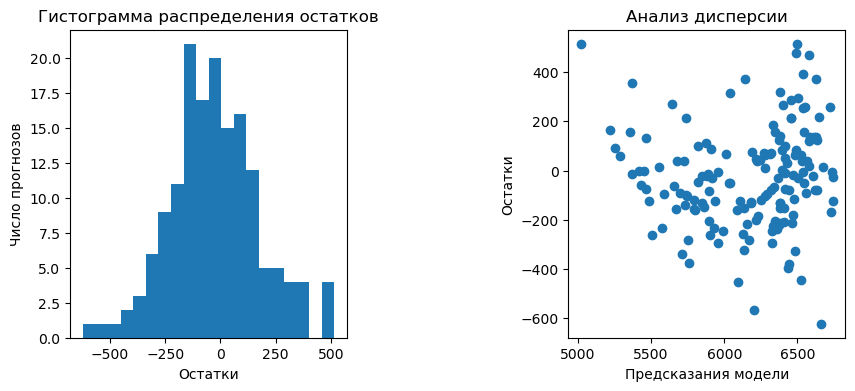

In [130]:
#Рассчитаем остатки
residuals = y_test - predictions_1

# построим гистограмму распределения количественных признаков и диаграмму рассеяния

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
plt.subplots_adjust(wspace=0.8, hspace=1.5)
axes[0].hist(residuals, bins = 20)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')
axes[0].set_ylabel('Число прогнозов')

axes[1].scatter(x = predictions_1, y = residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

***Распределение остатков***

Остатки имеют не нормальное распределение, график не симметричен относительно нуля, максимльное значение остатков модели варьируется от -200 до -150. Достаточно много ошибок в диапазоне +/- 200 от нуля. Модель даёт как завышенные, так и заниженные предсказания, но заниженных на 150-200 кг больше. 

***Анализ дисперсии ошибок***

В качественной модели  разница между минимумом и максимумом ошибок при любых прогнозных значениях модели должна быть постоянной, т е модель должна равномерно ошибаться. На этой диаграмме рассеяния видно, что дисперсия между значениями на оси Y не стабильна: она увеличивается по мере роста предскзаний. Начиная с прогнозов 6000 кг дисперсия ошибок сильно возрастает. 

Для улучшения качества работы модели в данной задаче можно было бы добавить больше данных с большими значениями удоя. Высокие показатели удоя (выше 6500) в исследуемой выборке - редкость, поэтому построить качественный прогноз, имея мало данных для анализа сложно.

In [69]:
rmse = mean_squared_error(y_test, predictions_1, squared=False)
mse = mean_squared_error(y_test, predictions_1)
mae = mean_absolute_error(y_test, predictions_1)
print(f'Корень среднеквадратической ошибки (RMSE) равен {rmse:.4f}')
print(f'Среднеквадратическая ошибка (MSE) равна {mse:.4f}')
print(f'Средняя абсолютная ошибка (MAE) равна {mae:.4f}')

Корень среднеквадратической ошибки (RMSE) равен 204.6381
Среднеквадратическая ошибка (MSE) равна 41876.7714
Средняя абсолютная ошибка (MAE) равна 159.5722


Значение показателя RMSE означает, что при прогнозе годового удоя в среднем модель ошибается примерно на 204,6 кг, средний квадрат ошибки (MSE) равен 41876 кг, а средняя абсолютная ошибка (MAE)  - 160 кг. Метрика МАЕ более устойчива к выбросам - ее лучше использовать, если у данных не очень выоская дисперсия, и выбросами можно пренебречь.
Метрика RMSE более чувствительна к прогнозам на основании данных с высокой дисперсией и выбросами. В нашем случае более точна метрика RMSE,  т к диаграмма дисперсии показывает достаточно большой разброс ошибок.  МАЕ не учитывает высокий разброс ошибок, т к при ее расчете ошибки не возводятся в квадрат.

Гистограмма распределения остатков тоже показывает, что значения средних ошибкок  находятся в интервале [-200; +200].
На основании рассчитанных метрик качества можно сделать вывод, что модель занижает прогнозные значения в среднем на 200 кг, т к на гистрограмме ошибок центр смещен в левую сторону. Но в 79,4% случае предсказания первой модели точнее средних значений целевого признака.

**Вторая модель**

Перед обучением второй модели трансформируем данные, чтобы снизить влияние факторов, не имеющих линейной зависимости с целевым признаком.
На диаграмме рассеяния наблюдения сгруппированы в два кластера, причём есть такое значение sugar_prot_rate, которое можно считать границей между кластерами. Чтобы изменить характер связи, преобразуем признак sugar_prot_rate в категориальный бинарный признак, использовав границу 0.9.

Зададим функцию, которая преобразует значения СПО в категориальный признак (более 0.9, менее 0.9)

In [88]:
def categorize_spr(sugar_prot_rate):
    if sugar_prot_rate <= 0.9:
        return 'меньше 0.9'
    if sugar_prot_rate > 0.9:
        return 'больше 0.9'
    
#Применим функцию к столбцу sugar_prot_rate и добавим дополнительный столбец 'spr_category'
ferma_main['spr_category'] = ferma_main['sugar_prot_rate'].apply(categorize_spr)
print(ferma_main.tail()) 

     index   id  yield_kg   eke  raw_protein  sugar_prot_rate  \
624    624  625      6812  15.4         1964             0.94   
625    625  626      5513  12.9         1700             0.88   
626    626  627      5970  14.4         1837             0.88   
627    627  628      5746  13.8         1994             0.89   
628    628  629      6503  16.2         2283             0.94   

               breed    pasture dad_breed  fat_%  protein_%      taste  \
624  РефлешнСоверинг  Равнинное    Айдиал   3.74      3.075  не вкусно   
625  РефлешнСоверинг  Равнинное   Соверин   3.64      3.073     вкусно   
626  РефлешнСоверинг  Холмистое   Соверин   3.64      3.075  не вкусно   
627  РефлешнСоверинг  Равнинное   Соверин   3.64      3.077     вкусно   
628   Вис Бик Айдиал  Холмистое   Соверин   3.71      3.076     вкусно   

             age spr_category  
624  более_2_лет   больше 0.9  
625  менее_2_лет   меньше 0.9  
626  более_2_лет   меньше 0.9  
627  более_2_лет   меньше 0.9  
628 

Введем новый признак ЭКЕ в квадрате, чтобы изменить характер связи между признаком ЕКЕ и целевым, посмотрим точечную диаграмму заивисмости между новым признаком и удоем.

In [89]:
def eke_square(eke):
    return eke**2
ferma_main['eke_squared'] = ferma_main['eke'].apply(eke_square)
print(ferma_main.tail()) 

     index   id  yield_kg   eke  raw_protein  sugar_prot_rate  \
624    624  625      6812  15.4         1964             0.94   
625    625  626      5513  12.9         1700             0.88   
626    626  627      5970  14.4         1837             0.88   
627    627  628      5746  13.8         1994             0.89   
628    628  629      6503  16.2         2283             0.94   

               breed    pasture dad_breed  fat_%  protein_%      taste  \
624  РефлешнСоверинг  Равнинное    Айдиал   3.74      3.075  не вкусно   
625  РефлешнСоверинг  Равнинное   Соверин   3.64      3.073     вкусно   
626  РефлешнСоверинг  Холмистое   Соверин   3.64      3.075  не вкусно   
627  РефлешнСоверинг  Равнинное   Соверин   3.64      3.077     вкусно   
628   Вис Бик Айдиал  Холмистое   Соверин   3.71      3.076     вкусно   

             age spr_category  eke_squared  
624  более_2_лет   больше 0.9       237.16  
625  менее_2_лет   меньше 0.9       166.41  
626  более_2_лет   меньше 0.9

Построим точечную диагнрамму зависимости между показетелями eke_squared и yield_kg.

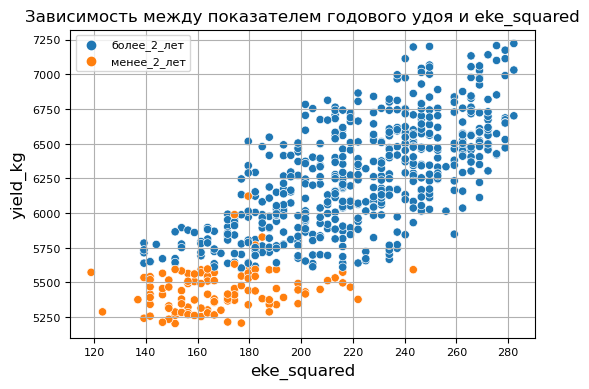

In [94]:
plt.figure(figsize=[6, 4])
plt.title('Зависимость между показателем годового удоя и eke_squared', fontsize=12)
sns.scatterplot(data = ferma_main, x = 'eke_squared', y='yield_kg', hue = 'age')
plt.xlabel('eke_squared', fontsize = 12)
plt.ylabel('yield_kg', fontsize = 12)
plt.legend(fontsize = 8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid(True)

Посчитаем коэффициенты корреляции Спирмана между yield_kg и покзателями eke и eke_squared.

In [95]:
rho_eke, p = spearmanr(ferma_main['yield_kg'], ferma_main['eke'])
rho_eke_squared, p = spearmanr(ferma_main['yield_kg'], ferma_main['eke_squared'])

print('Коэффициент корреляции Спирмана между целевым признаком и EKE: ', rho_eke)
print('Коэффициент корреляции Спирмана между целевым признаком и EKE_squared: ', rho_eke_squared)

Коэффициент корреляции Спирмана между целевым признаком и EKE:  0.7651443116006692
Коэффициент корреляции Спирмана между целевым признаком и EKE_squared:  0.7651443116006692


Видно, что коэффициенты корреляции и диаграммы рассеяния существенно не поменялись у нового признака. Введем еще один категориальный признак, после этого оценим корреляцию показателей по другой шкале (Фи). 

На диаграммах рассеяния видна ощутимая разница значений целевого признака в определенных интервалах значения fat_%: при значениях от 3,675% значения целевого признака становятся резко выше. Признак fat_% можно преобразовать в категориальный и посмотреть, как это повлияет на качество работы модели.

Зададим функцию, которая разделит значения признака fat_% на 2 группы: менее 3,68% и от 3,68%.

In [96]:
def categorize_fat(fat):
    if fat < 3.675 :
        return 'менее 3.68'
    if fat >= 3.675:
        return 'более 3.68'
    
#Применим функцию к столбцу fat_% и добавим дополнительный столбец 'fat_%_category'
ferma_main['fat_%_category'] = ferma_main['fat_%'].apply(categorize_fat)
print(ferma_main.tail()) 

     index   id  yield_kg   eke  raw_protein  sugar_prot_rate  \
624    624  625      6812  15.4         1964             0.94   
625    625  626      5513  12.9         1700             0.88   
626    626  627      5970  14.4         1837             0.88   
627    627  628      5746  13.8         1994             0.89   
628    628  629      6503  16.2         2283             0.94   

               breed    pasture dad_breed  fat_%  protein_%      taste  \
624  РефлешнСоверинг  Равнинное    Айдиал   3.74      3.075  не вкусно   
625  РефлешнСоверинг  Равнинное   Соверин   3.64      3.073     вкусно   
626  РефлешнСоверинг  Холмистое   Соверин   3.64      3.075  не вкусно   
627  РефлешнСоверинг  Равнинное   Соверин   3.64      3.077     вкусно   
628   Вис Бик Айдиал  Холмистое   Соверин   3.71      3.076     вкусно   

             age spr_category  eke_squared fat_%_category  
624  более_2_лет   больше 0.9       237.16     более 3.68  
625  менее_2_лет   меньше 0.9       166.41  

После введения новых признаков посчитаем коэффициенты корреляции Фи.

In [97]:
ferma_main_phik_two = ferma_main[['yield_kg', 'eke', 'eke_squared', 'raw_protein', 'sugar_prot_rate', 
                                  'spr_category', 'breed', 'pasture', 'dad_breed', 'fat_%', 'fat_%_category',
                                  'protein_%', 'taste', 'age']]
ferma_phik_matrix_two = ferma_main_phik_two.phik_matrix(interval_cols = ['yield_kg', 'eke', 'eke_squared', 'raw_protein',
                                                 'sugar_prot_rate', 'fat_%', 'protein_%'])
display(ferma_phik_matrix_two)

yield_kg       eke  eke_squared  raw_protein  \
yield_kg         1.000000  0.720719     0.722116     0.463224   
eke              0.720719  1.000000     0.979902     0.456484   
eke_squared      0.722116  0.979902     1.000000     0.451582   
raw_protein      0.463224  0.456484     0.451582     1.000000   
sugar_prot_rate  0.661359  0.591190     0.584376     0.387188   
spr_category     0.999947  0.900428     0.880770     0.537071   
breed            0.164744  0.123086     0.074709     0.090925   
pasture          0.279540  0.106758     0.148222     0.096474   
dad_breed        0.519915  0.171355     0.152239     0.000000   
fat_%            0.707654  0.715914     0.714925     0.397380   
fat_%_category   0.935295  0.905673     0.894265     0.519955   
protein_%        0.058970  0.000000     0.000000     0.202474   
taste            0.173122  0.272265     0.305768     0.176480   
age              0.998101  0.771596     0.766892     0.351685   

                 sugar_prot_rate  spr_category     breed   pasture  dad_breed  \
yield_kg                0.661359      0.999947  0.164744  0.279540   0.519915   
eke                     0.591190      0.900428  0.123086  0.106758   0.171355   
eke_squared             0.584376      0.880770  0.074709  0.148222   0.152239   
raw_protein             0.387188      0.537071  0.090925  0.096474   0.000000   
sugar_prot_rate         1.000000      1.000000  0.062660  0.155349   0.425601   
spr_category            1.000000      1.000000  0.028933  0.143022   0.407797   
breed                   0.062660      0.028933  1.000000  0.213218   0.089330   
pasture                 0.155349      0.143022  0.213218  1.000000   0.000000   
dad_breed               0.425601      0.407797  0.089330  0.000000   1.000000   
fat_%                   0.645581      0.922373  0.222825  0.000000   0.000000   
fat_%_category          0.930490      0.925959  0.145874  0.000000   0.042724   
protein_%               0.073787      0.000000  0.361851  0.099908   0.134582   
taste                   0.572702      0.100949  0.000000  0.269063   0.000000   
age                     0.744410      0.748062  0.057295  0.128455   0.355817   

                    fat_%  fat_%_category  protein_%     taste       age  
yield_kg         0.707654        0.935295   0.058970  0.173122  0.998101  
eke              0.715914        0.905673   0.000000  0.272265  0.771596  
eke_squared      0.714925        0.894265   0.000000  0.305768  0.766892  
raw_protein      0.397380        0.519955   0.202474  0.176480  0.351685  
sugar_prot_rate  0.645581        0.930490   0.073787  0.572702  0.744410  
spr_category     0.922373        0.925959   0.000000  0.100949  0.748062  
breed            0.222825        0.145874   0.361851  0.000000  0.057295  
pasture          0.000000        0.000000   0.099908  0.269063  0.128455  
dad_breed        0.000000        0.042724   0.134582  0.000000  0.355817  
fat_%            1.000000        1.000000   0.000000  0.198793  0.677913  
fat_%_category   1.000000        1.000000   0.000000  0.217017  0.608881  
protein_%        0.000000        0.000000   1.000000  0.143857  0.000000  
taste            0.198793        0.217017   0.143857  1.000000  0.165974  
age              0.677913        0.608881   0.000000  0.165974  1.000000

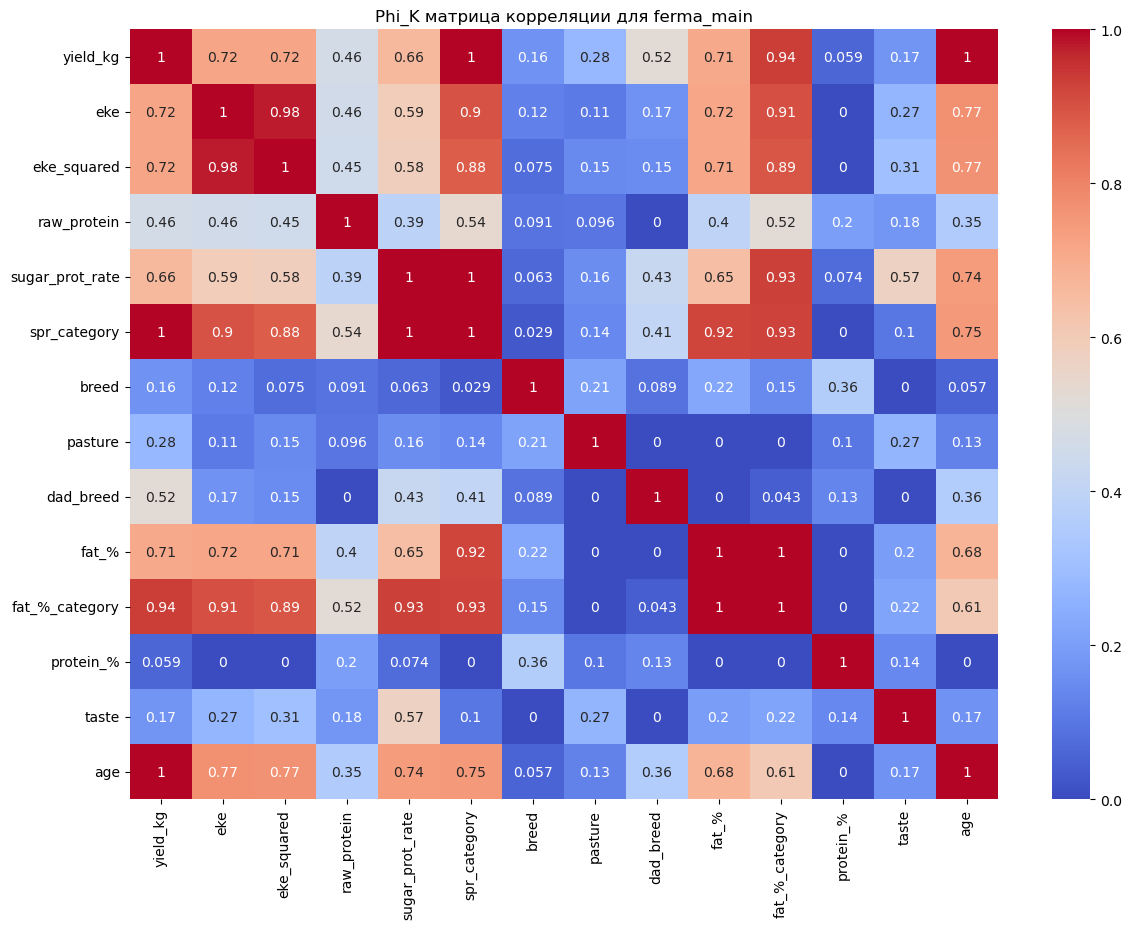

In [98]:
# Визуализация матрицы корреляции с использованием phik

plt.figure(figsize=(14, 10))
sns.heatmap(ferma_phik_matrix_two, annot=True, cmap='coolwarm')
plt.title('Phi_K матрица корреляции для ferma_main')
plt.show()

Видим максимльные коэффиценты корреляции Фи между целевым признаком и показателем возраста (99,8%) и spr_category (99,9%). Очевидно, что перевод показателя spr в категориальный максимально усилил связь между удоем и этим показателем.

То же самое с показателем fat_%: после перевода в категориальный бинарный признак связь между удоем и жирностью выросла с 60% до 94%.
Наличие высокой корреляции (рассчитанной на основе коэффицента Фи) между категориальными признаками не ухудшит работу модели. А корреляция между количественными признаками приведет к ухудшению качества расчетов (линейная зависимость между уравнениями в системе означает отсутствие единственного решения - система либо не имеет решения, либо бесконечное число решений). Поэтому нужно удалить количественные признаки, имеюще высокую корреляцию с другими количественными. В данном случае это показатель eke (97% корреляция с eke_squared).  Так же уберем показатель fat_%, т к мы перевели его в категориальный признак, имеющий значительно более высокую корреляцию с целевым.
При обучении модели исключим признак еке из выборки.

Разделим признаки на входные и целевые.

Разделим признаки на категориальные и количественные, отмасштабируем количественные и закодируем категориальные.

In [101]:
# сохранение входных признаков в переменную X
X = ferma_main.drop('yield_kg', axis = 1)


# сохранение целевого признака в переменную y
y = ferma_main['yield_kg']

X_train_2, X_test_2, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE)

cat_col_names = ['spr_category', 'breed', 'pasture', 'dad_breed', 'fat_%_category','taste', 'age']
num_col_names = ['eke_squared', 'raw_protein', 'sugar_prot_rate', 'protein_%']

# создадим переменную с экземпляром класса StandardScaler()
scaler = StandardScaler()

# обучим и трансформируем количественные признаки из тренировочной выборки 
X_train_scaled = scaler.fit_transform(X_train_2[num_col_names])

# выполним преобразование количественных признаков в тестовой выборке
X_test_scaled = scaler.transform(X_test_2[num_col_names])

# создадим переменную с экземпляром класса OneHotEncoder()
encoder = OneHotEncoder(drop = 'first', sparse_output = False)
#df = pd.get_dummies(df, drop_first=True)

# обучими трансформируем категориальные признаки из тренировочной выборки 
X_train_ohe = encoder.fit_transform(X_train_2[cat_col_names])

# выполним преобразование категориальных признаков в тестовой выборке
X_test_ohe = encoder.transform(X_test_2[cat_col_names])

# получим от кодировщика список новых столбцов и сохраните в новой переменной 
encoder_col_names = encoder.get_feature_names_out()

# создаём тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

# объединяем все преобразованные данные в тренировочный и тестовый датафреймы
# сбрасываем индексы в датафрейме с числовыми индексами, чтобы избежать ошибок

X_train_2 = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test_2 = pd.concat([X_test_ohe, X_test_scaled], axis=1)

Обучим вторую модель линейной регрессии.

In [102]:
# инициализируйте модель линейной регрессии
model_lr_two  = LinearRegression() 

# обучите модель на тренировочных данных
model_lr_two.fit(X_train_2, y_train) 

# получите предсказания модели на тестовых данных 
# сохраните результат в переменную predictions
predictions_2 = model_lr_two.predict(X_test_2)

Оценим качество модели, рассчитаем R², проанализируем остатки с помощью графиков.

In [103]:
r2 = r2_score(y_test, predictions_2) 
print(f'Коэффициент детерминации второй модели равен {r2:.4f}')

Коэффициент детерминации второй модели равен 0.8168


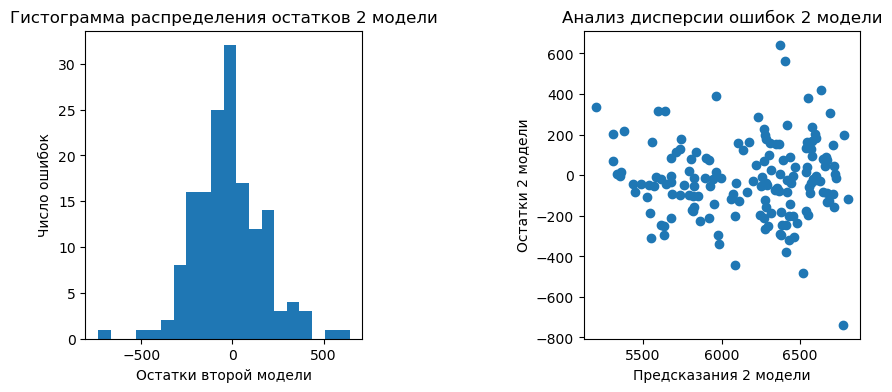

In [113]:
#Рассчитаем остатки
residuals = y_test - predictions_2

# построим гистограмму распределения количественных признаков и диаграмму рассеяния

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
plt.subplots_adjust(wspace=0.8, hspace=1.5)
axes[0].hist(residuals, bins = 20)
axes[0].set_title('Гистограмма распределения остатков 2 модели')
axes[0].set_xlabel('Остатки второй модели')
axes[0].set_ylabel('Число прогнозов')

axes[1].scatter(x = predictions_2, y = residuals)
axes[1].set_xlabel('Предсказания 2 модели')
axes[1].set_ylabel('Остатки 2 модели')
axes[1].set_title('Анализ дисперсии ошибок 2 модели')
plt.show()

Распределение остатков второй модели более симметричное, для максимального числа прогонозов (пик на графике) ошибки равны нулю, и число заниженных прогнозных значений (отклонение минус 200) меньше, чем в первой модели ошибок (диаграмма распределения "тоньше").

Дисперсия ошибок меньше, чем в первой модели, до значений прогнозов 6500 кг, но нельзя назвать дисперсию ошибок равномерной.

In [118]:
rmse = mean_squared_error(y_test, predictions_2, squared=False)
mse = mean_squared_error(y_test, predictions_2)
mae = mean_absolute_error(y_test, predictions_2)
print(f'Корень среднеквадратической ошибки (RMSE) 2ой модели равен {rmse:.4f}')
print(f'Среднеквадратическая ошибка (MSE) 2ой модели равна {mse:.4f}')
print(f'Средняя абсолютная ошибка (MAE) 2ой модели равна {mae:.4f}')

Корень среднеквадратической ошибки (RMSE) 2ой модели равен 193.1067
Среднеквадратическая ошибка (MSE) 2ой модели равна 37290.1928
Средняя абсолютная ошибка (MAE) 2ой модели равна 146.3780


Во второй модели, так же как и в первой, более показательным коэффициентом является RMSE, т к ошибки несмотря на коррекцию исходных данных все равно имеют высокий разброс. RMSE второй модели равен 193 кг - это меньше, чем в первой, на 5%.   
Гистограмма распределения остатков более центрирована, чем в первой модели, смещения от нуля нет, т е средняя ошибка равна 0.
Можн сделать вывод, что после трансформации признака еке, переведения признаков СПО и fat_% в категориальные мы усилили связи между входными и целевым признками, добившись улучшения точности предсказаний модели.

На основании рассчитанных метрик качества можно сделать вывод, что вторая модель ошибается в среднем на 193 кг, в обе стороны. В 81,7% случаев предсказания второй модели точнее средних значений целевого признака. В плане прогнозов вторая модель на 2% эффективнее, чем первая.

**Третья модель**

Добавим признак Имя Папы из файла ferma_dad.csv, соединив его с остальными данными ferma_main.csv по ключу.

In [119]:
ferma_main = ferma_main.merge(ferma_dad, on='id', how = 'left') 
display(ferma_main.head())

index  id  yield_kg   eke  raw_protein  sugar_prot_rate            breed  \
0      0   1      5863  14.2         1743            0.890   Вис Бик Айдиал   
1      1   2      5529  12.8         2138            0.890   Вис Бик Айдиал   
2      2   3      5810  14.0         1854            0.885  РефлешнСоверинг   
3      3   4      5895  12.4         2012            0.885  РефлешнСоверинг   
4      4   5      5302  12.8         1675            0.885   Вис Бик Айдиал   

     pasture dad_breed  fat_%  protein_%      taste          age spr_category  \
0  Равнинное    Айдиал   3.58      3.076     вкусно  более_2_лет   меньше 0.9   
1  Равнинное   Соверин   3.54      3.079     вкусно  менее_2_лет   меньше 0.9   
2  Холмистое   Соверин   3.59      3.074  не вкусно  более_2_лет   меньше 0.9   
3  Холмистое    Айдиал   3.40      3.075  не вкусно  более_2_лет   меньше 0.9   
4  Равнинное   Соверин   3.73      3.073     вкусно  менее_2_лет   меньше 0.9   

   eke_squared fat_%_category  dad_name  
0       201.64     менее 3.68    Буйный  
1       163.84     менее 3.68  Соловчик  
2       196.00     менее 3.68     Барин  
3       153.76     менее 3.68    Буйный  
4       163.84     более 3.68     Барин

Посмотрим коэффициенты корреляции между всеми признаками в обновленной таблице.

<Axes: >

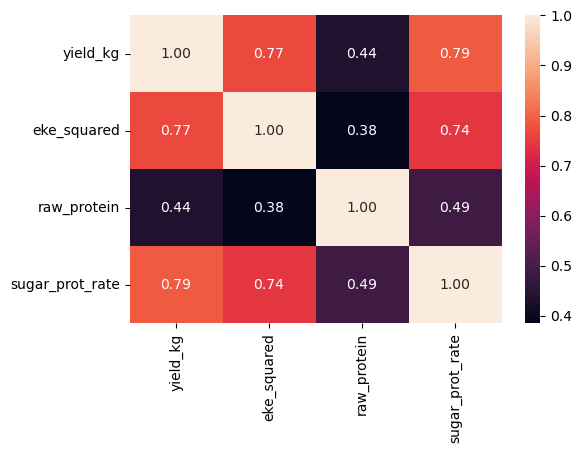

In [121]:
ferma_main_col_2 = ferma_main[['yield_kg', 'eke_squared', 'raw_protein', 'sugar_prot_rate']]

plt.figure(figsize = (6,4))
sns.heatmap(ferma_main_col_2.corr(method = 'spearman'), annot=True, fmt='.2f') 

In [122]:
ferma_main_phik_three = ferma_main[['yield_kg', 'eke_squared', 'raw_protein', 'sugar_prot_rate', 'protein_%',
                                  'spr_category', 'breed', 'pasture', 'dad_breed', 
                                  'fat_%_category', 'age', 'taste', 'dad_name']]
ferma_phik_matrix_three = ferma_main_phik_three.phik_matrix(interval_cols = ['yield_kg', 'eke_squared', 'raw_protein', 'protein_%',
                                                 'sugar_prot_rate'])

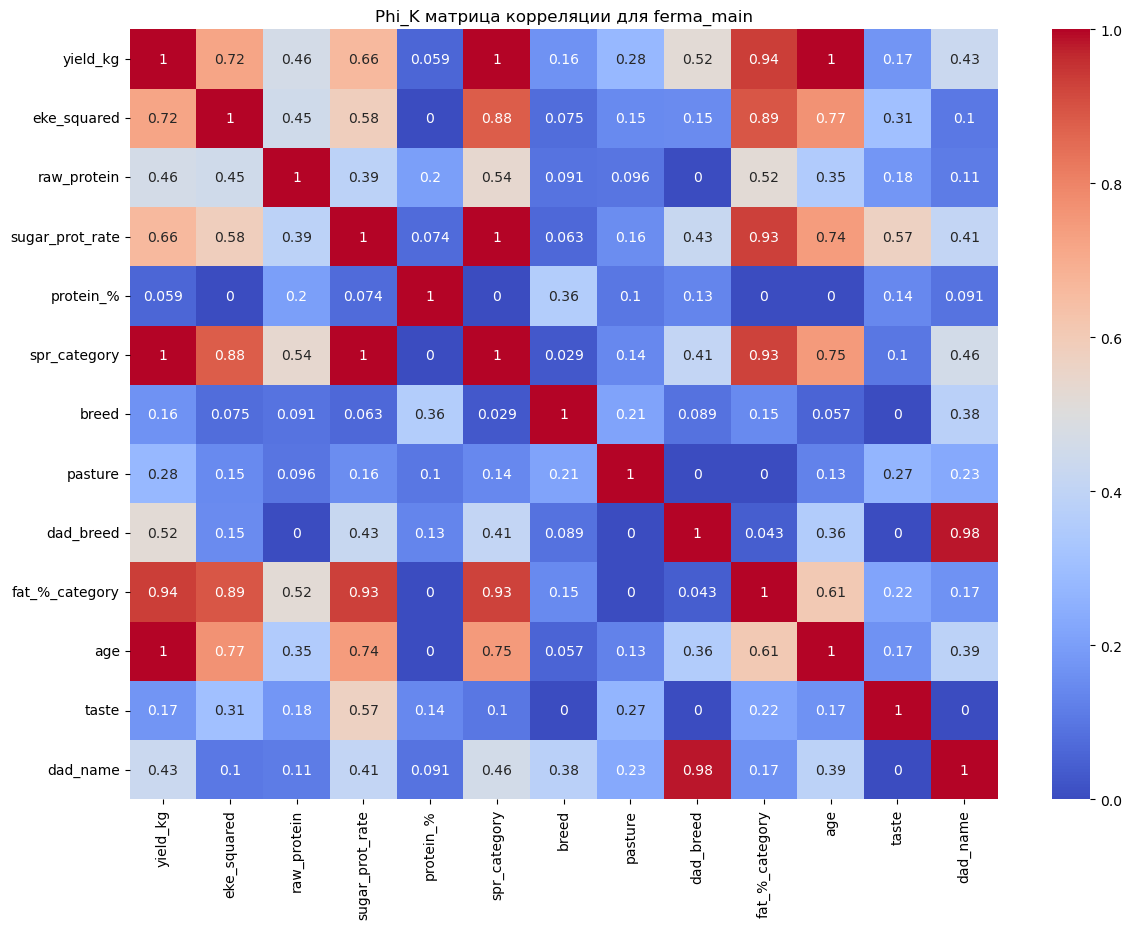

In [123]:
# Визуализация матрицы корреляции с использованием phik

plt.figure(figsize=(14, 10))
sns.heatmap(ferma_phik_matrix_three, annot=True, cmap='coolwarm')
plt.title('Phi_K матрица корреляции для ferma_main')
plt.show()

Уберем из входных признаков породу, тк на диаграмме рассеяния было видно отсутствие взаимосвязи между породой коровы и удоем, в то время как связь между породой папы коровы и удоем была очевидна. 

In [125]:
# сохранение входных признаков в переменную X
X = ferma_main.drop('yield_kg', axis = 1)


# сохранение целевого признака в переменную y
y = ferma_main['yield_kg']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE)

cat_col_names_3 = ['spr_category', 'pasture', 'dad_breed', 'fat_%_category', 'age', 'dad_name']
num_col_names_3 = ['eke_squared', 'raw_protein', 'protein_%', 'sugar_prot_rate']

# создадим переменную с экземпляром класса StandardScaler()
scaler_3 = StandardScaler()

# обучим и трансформируем количественные признаки из тренировочной выборки 
X_train_scaled = scaler_3.fit_transform(X_train[num_col_names_3])

# выполним преобразование количественных признаков в тестовой выборке
X_test_scaled = scaler_3.transform(X_test[num_col_names_3])

# создадим переменную с экземпляром класса OneHotEncoder()
encoder_3 = OneHotEncoder(drop = 'first', sparse_output = False)

# обучими трансформируем категориальные признаки из тренировочной выборки 
X_train_ohe = encoder_3.fit_transform(X_train[cat_col_names_3])

# выполним преобразование категориальных признаков в тестовой выборке
X_test_ohe = encoder_3.transform(X_test[cat_col_names_3])

# получим от кодировщика список новых столбцов и сохраните в новой переменной 
encoder_col_names = encoder_3.get_feature_names_out()

# создаём тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names_3)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names_3)

# объединяем все преобразованные данные в тренировочный и тестовый датафреймы
# сбрасываем индексы в датафрейме с числовыми индексами, чтобы избежать ошибок

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

Обучим третью модель линейной регрессии.

In [147]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471 entries, 0 to 470
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   spr_category_меньше 0.9    471 non-null    float64
 1   pasture_Холмистое          471 non-null    float64
 2   dad_breed_Соверин          471 non-null    float64
 3   fat_%_category_менее 3.68  471 non-null    float64
 4   age_менее_2_лет            471 non-null    float64
 5   dad_name_Буйный            471 non-null    float64
 6   dad_name_Геркулес          471 non-null    float64
 7   dad_name_Соловчик          471 non-null    float64
 8   eke_squared                471 non-null    float64
 9   raw_protein                471 non-null    float64
 10  protein_%                  471 non-null    float64
 11  sugar_prot_rate            471 non-null    float64
dtypes: float64(12)
memory usage: 44.3 KB


In [126]:
# инициализируем модель линейной регрессии
model_lr_three  = LinearRegression() 

# обучим модель на тренировочных данных
model_lr_three.fit(X_train, y_train) 

# получим предсказания модели на тестовых данных 
# сохраним результат в переменную predictions
predictions_3 = model_lr_three.predict(X_test)

Оценим качество третьей модели, рассчитаем R², проанализируем остатки с помощью графиков.

In [127]:
r2 = r2_score(y_test, predictions_3) 
print(f'Коэффициент детерминации третьей модели равен {r2:.4f}')

Коэффициент детерминации третьей модели равен 0.8236


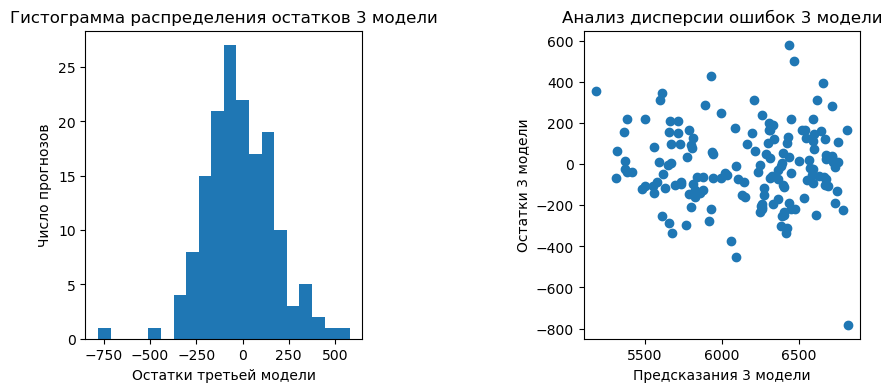

In [134]:
#Рассчитаем остатки
residuals = y_test - predictions_3

# построим гистограмму распределения количественных признаков и диаграмму рассеяния

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
plt.subplots_adjust(wspace=0.8, hspace=1.5)
axes[0].hist(residuals, bins = 20)
axes[0].set_title('Гистограмма распределения остатков 3 модели')
axes[0].set_xlabel('Остатки третьей модели')
axes[0].set_ylabel('Число прогнозов')

axes[1].scatter(x = predictions_3, y = residuals)
axes[1].set_xlabel('Предсказания 3 модели')
axes[1].set_ylabel('Остатки 3 модели')
axes[1].set_title('Анализ дисперсии ошибок 3 модели')
plt.show()

Рассчитаем метрики третьей модели.

In [135]:
rmse = mean_squared_error(y_test, predictions_3, squared=False)
mse = mean_squared_error(y_test, predictions_3)
mae = mean_absolute_error(y_test, predictions_3)
print(f'Корень среднеквадратической ошибки (RMSE) 3 модели равен {rmse:.4f}')
print(f'Среднеквадратическая ошибка (MSE) 3 модели равна {mse:.4f}')
print(f'Средняя абсолютная ошибка (MAE) 3 модели равна {mae:.4f}')

Корень среднеквадратической ошибки (RMSE) 3 модели равен 189.5044
Среднеквадратическая ошибка (MSE) 3 модели равна 35911.9171
Средняя абсолютная ошибка (MAE) 3 модели равна 147.6928


Если сравнивать показатели r2, распределение и дисперсию остатков, то лучшие показатели  -  у третьй модели. 
У нее максимальный (82,4%) коэффициент детерминации, т е в 82,4% случаев предсказания модели точнее среднего значения целевого признака. Распределение остатков третьей модели похоже на нормальное, с самым высоким пиком в нуле (т е больше всего ошибок модели равны нулю). 

Дисперсия ошибок второй и третьй модели примерно одинакова: до прогноза 6500 кг ошибки в пределах 400 от нулевой в обе стороны, начиная со значения 6500 кг дисперсия ошибок резко увеличивается. Это можно объяснить качеством исходных данных: в исходной таблице очень мало таких высоких значений, поэтому делать более точные предсказания основываясь на малой выборке проблематично. По логике нужно добавить в исходную таблицу информацию о коровах с удоями от 6500 кг в год из других источников.

Метрика RMSE, наиболее адекватная для оценки качества модели равна 189, это лучше, чем в 1 и 2 моделях.

Посчитаем доверительный интервал прогноза третьей модели. Посчитаем диапазон значений, в который попадает 95% всех прогнозных значений модели.

In [136]:
predictions_series = pd.Series(predictions_3)

print (f'Доверительный интервал от {predictions_series.quantile(0.025):.2f} до {predictions_series.quantile(0.975):.2f}')


Доверительный интервал от 5367.27 до 6754.54


Чтобы спрогнозировать удой коров, которых фермер хочет купить, добавим в данные cow_buy  недостающие признаки:  ЭКЕ, Сырой протеин, СПО (Сахаро-протеиновое соотношение), возьмем их из датасета ferma_main.csv средние значения каждого из признаков и увеличим их на 5%.

In [137]:
#Посчитаем средние значения eke, raw_protein и sugar_prot_rate.
eke_mean = round(ferma_main['eke'].mean(), 2)

raw_protein_mean = round(ferma_main['raw_protein'].mean(), 2)

sugar_prot_rate_mean = round(ferma_main['sugar_prot_rate'].mean(), 2)

print('eke_maen: ', eke_mean, '\n',    
     'raw_protein_mean: ', raw_protein_mean, '\n',      
     'sugar_prot_rate_mean: ', sugar_prot_rate_mean)

eke_maen:  14.55 
 raw_protein_mean:  1923.76 
 sugar_prot_rate_mean:  0.91


Корректнее взять медианы, т к данные распределены не очень равномерно (это было видно на диаграммах размаха и гистограммах). Показатель ЕКЕ нужно возвестив квадрат, т к в признаках используемой модели эта метрика в квадрате.


In [138]:
cow_buy.insert (loc= 7 , column='eke_squared', value=(eke_mean*1.05)**2)
cow_buy.insert (loc= 8 , column='raw_protein', value=raw_protein_mean*1.05)
cow_buy.insert (loc= 9 , column='sugar_prot_rate', value=sugar_prot_rate_mean*1.05)
cow_buy.insert(loc = 10, column = 'spr_category', value = 'больше 0.9')
cow_buy.insert(loc = 11, column = 'taste', value = 0)
print(cow_buy.head())

             breed    pasture dad_breed  dad_name  current_fat_%  \
0   Вис Бик Айдиал  Холмистое    Айдиал  Геркулес           3.58   
1   Вис Бик Айдиал  Равнинное   Соверин    Буйный           3.54   
2  РефлешнСоверинг  Равнинное   Соверин     Барин           3.59   
3  РефлешнСоверинг  Холмистое    Айдиал    Буйный           3.40   
4  РефлешнСоверинг  Равнинное    Айдиал    Буйный           3.64   

   current_protein_%          age  eke_squared  raw_protein  sugar_prot_rate  \
0              3.076  более_2_лет   233.402006     2019.948           0.9555   
1              3.081  менее_2_лет   233.402006     2019.948           0.9555   
2              3.074  более_2_лет   233.402006     2019.948           0.9555   
3              3.061  более_2_лет   233.402006     2019.948           0.9555   
4              3.074  более_2_лет   233.402006     2019.948           0.9555   

  spr_category  taste  
0   больше 0.9      0  
1   больше 0.9      0  
2   больше 0.9      0  
3   больше 0.9

In [139]:
print(cow_buy.head())

             breed    pasture dad_breed  dad_name  current_fat_%  \
0   Вис Бик Айдиал  Холмистое    Айдиал  Геркулес           3.58   
1   Вис Бик Айдиал  Равнинное   Соверин    Буйный           3.54   
2  РефлешнСоверинг  Равнинное   Соверин     Барин           3.59   
3  РефлешнСоверинг  Холмистое    Айдиал    Буйный           3.40   
4  РефлешнСоверинг  Равнинное    Айдиал    Буйный           3.64   

   current_protein_%          age  eke_squared  raw_protein  sugar_prot_rate  \
0              3.076  более_2_лет   233.402006     2019.948           0.9555   
1              3.081  менее_2_лет   233.402006     2019.948           0.9555   
2              3.074  более_2_лет   233.402006     2019.948           0.9555   
3              3.061  более_2_лет   233.402006     2019.948           0.9555   
4              3.074  более_2_лет   233.402006     2019.948           0.9555   

  spr_category  taste  
0   больше 0.9      0  
1   больше 0.9      0  
2   больше 0.9      0  
3   больше 0.9

Поскольку в тестовой выборке третьей модели был покзатель fat_%_category, а в выборке cow_buy этого признака нет, нужно его лобавить, рассчитав исходя из показателя curret_protein_%.

In [140]:
cow_buy['fat_%_category'] = cow_buy['current_fat_%'].apply(categorize_fat)
cow_buy.rename(columns = {'current_protein_%' : 'protein_%'}, inplace = True )
print(cow_buy.tail()) 

              breed    pasture dad_breed  dad_name  current_fat_%  protein_%  \
15  РефлешнСоверинг  Холмистое    Айдиал    Буйный           3.40      3.065   
16   Вис Бик Айдиал  Холмистое   Соверин  Соловчик           3.73      3.079   
17  РефлешнСоверинг  Равнинное   Соверин  Геркулес           3.77      3.053   
18   Вис Бик Айдиал  Равнинное   Соверин    Буйный           3.34      3.069   
19  РефлешнСоверинг  Равнинное    Айдиал    Буйный           3.64      3.074   

            age  eke_squared  raw_protein  sugar_prot_rate spr_category  \
15  более_2_лет   233.402006     2019.948           0.9555   больше 0.9   
16  более_2_лет   233.402006     2019.948           0.9555   больше 0.9   
17  менее_2_лет   233.402006     2019.948           0.9555   больше 0.9   
18  более_2_лет   233.402006     2019.948           0.9555   больше 0.9   
19  более_2_лет   233.402006     2019.948           0.9555   больше 0.9   

    taste fat_%_category  
15      0     менее 3.68  
16      0     

In [141]:
print(X_train.head())

   spr_category_меньше 0.9  pasture_Холмистое  dad_breed_Соверин  \
0                      0.0                1.0                1.0   
1                      1.0                1.0                1.0   
2                      1.0                0.0                0.0   
3                      0.0                1.0                0.0   
4                      1.0                0.0                0.0   

   fat_%_category_менее 3.68  age_менее_2_лет  dad_name_Буйный  \
0                        0.0              0.0              0.0   
1                        1.0              1.0              0.0   
2                        1.0              0.0              1.0   
3                        1.0              0.0              1.0   
4                        1.0              0.0              0.0   

   dad_name_Геркулес  dad_name_Соловчик  eke_squared  raw_protein  protein_%  \
0                0.0                1.0     1.577968     1.079523  -0.679069   
1                0.0              

Подготовим данные в cow_buy для прогноза.

In [143]:
cow_buy_ohe = encoder_3.transform(cow_buy[cat_col_names_3])
encoder_col_names = encoder_3.get_feature_names_out() 
cow_buy_ohe = pd.DataFrame(cow_buy_ohe, columns = encoder_col_names)

cow_buy_scaled = scaler_3.transform(cow_buy[num_col_names_3])
cow_buy_scaled = pd.DataFrame(cow_buy_scaled, columns = num_col_names_3)

cow_buy_test = pd.concat([cow_buy_scaled, cow_buy_ohe], axis = 1)

Посмотрим на данные в выборке, используемой для обучения модели, и в выборке, по которой нужно делать прогноз. Нужно убедиться, что столбцы в выборках одинаковые.

In [144]:
print(X_train.info())
print(cow_buy_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471 entries, 0 to 470
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   spr_category_меньше 0.9    471 non-null    float64
 1   pasture_Холмистое          471 non-null    float64
 2   dad_breed_Соверин          471 non-null    float64
 3   fat_%_category_менее 3.68  471 non-null    float64
 4   age_менее_2_лет            471 non-null    float64
 5   dad_name_Буйный            471 non-null    float64
 6   dad_name_Геркулес          471 non-null    float64
 7   dad_name_Соловчик          471 non-null    float64
 8   eke_squared                471 non-null    float64
 9   raw_protein                471 non-null    float64
 10  protein_%                  471 non-null    float64
 11  sugar_prot_rate            471 non-null    float64
dtypes: float64(12)
memory usage: 44.3 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 

Порядок столбцов в X_train и cow_buy_test разный. Приведем порядок столбцов в cow_buy_test к такому же виду, как в X_train (к порядку, на котором обучалась модель).

In [149]:
cow_buy_test = cow_buy_test[['spr_category_меньше 0.9', 'pasture_Холмистое', 'dad_breed_Соверин',\
                            'fat_%_category_менее 3.68', 'age_менее_2_лет', 'dad_name_Буйный',\
                            'dad_name_Геркулес', 'dad_name_Соловчик', 'eke_squared', 'raw_protein',\
                            'protein_%', 'sugar_prot_rate']]

In [150]:
print(X_train.info())
print(cow_buy_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471 entries, 0 to 470
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   spr_category_меньше 0.9    471 non-null    float64
 1   pasture_Холмистое          471 non-null    float64
 2   dad_breed_Соверин          471 non-null    float64
 3   fat_%_category_менее 3.68  471 non-null    float64
 4   age_менее_2_лет            471 non-null    float64
 5   dad_name_Буйный            471 non-null    float64
 6   dad_name_Геркулес          471 non-null    float64
 7   dad_name_Соловчик          471 non-null    float64
 8   eke_squared                471 non-null    float64
 9   raw_protein                471 non-null    float64
 10  protein_%                  471 non-null    float64
 11  sugar_prot_rate            471 non-null    float64
dtypes: float64(12)
memory usage: 44.3 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 

In [151]:
# получим предсказания модели на реальных данных 
# сохраним результат в переменную predictions_to_buy
predictions_to_buy = model_lr_three.predict(cow_buy_test)

In [152]:
forecast_series = pd.Series(predictions_to_buy)
print(forecast_series)

0     6450.896377
1     6149.124244
2     6083.781231
3     6580.006820
4     6380.731289
5     6403.975905
6     6450.896377
7     6368.753827
8     6083.781231
9     6217.507618
10    6598.963737
11    6674.608361
12    6966.225517
13    5956.274965
14    6083.781231
15    6544.289415
16    6384.659306
17    6651.424507
18    6458.047339
19    6380.731289
dtype: float64


In [153]:
yield_prognose = forecast_series.to_frame(name='yield_prognose')
display(yield_prognose)


yield_prognose
0      6450.896377
1      6149.124244
2      6083.781231
3      6580.006820
4      6380.731289
5      6403.975905
6      6450.896377
7      6368.753827
8      6083.781231
9      6217.507618
10     6598.963737
11     6674.608361
12     6966.225517
13     5956.274965
14     6083.781231
15     6544.289415
16     6384.659306
17     6651.424507
18     6458.047339
19     6380.731289

Добавим столбец с признаком, выполнены ли условия:
- удой более 6000 кг в год;
- значение прогноза попадает в доверительный интервал (не более 6754 кг).

In [154]:
def condition(prognose):
    if (prognose >= 6000)&(prognose<=6754):
        return 'подходит'
    else:
        return 'НЕ подходит'

yield_prognose['result'] = yield_prognose['yield_prognose'].apply(condition)
display(yield_prognose)
print(len(yield_prognose[yield_prognose['result']=='подходит']), 'коров из предложенной выборки дают удой более 6000 кг в год.')

yield_prognose       result
0      6450.896377     подходит
1      6149.124244     подходит
2      6083.781231     подходит
3      6580.006820     подходит
4      6380.731289     подходит
5      6403.975905     подходит
6      6450.896377     подходит
7      6368.753827     подходит
8      6083.781231     подходит
9      6217.507618     подходит
10     6598.963737     подходит
11     6674.608361     подходит
12     6966.225517  НЕ подходит
13     5956.274965  НЕ подходит
14     6083.781231     подходит
15     6544.289415     подходит
16     6384.659306     подходит
17     6651.424507     подходит
18     6458.047339     подходит
19     6380.731289     подходит

18 коров из предложенной выборки дают удой более 6000 кг в год.


По прогнозам третьей модели 14 коров из выборки для покупки соответствуют необходимому условию (годовой удой более 6000 кг), и значения целевого признака попадают в доверительный интервал (не более 6754 кг).

### Обучение модели логистической регрессии

Обучим модель на тех же данных, которые ипсользовались в 3 модели.

In [156]:
# объявляем константы в соответствии с PEP-8
RANDOM_STATE = 42
random.seed(RANDOM_STATE)

X = ferma_main.drop(columns='taste', axis = 2)
y = ferma_main['taste']
y = y.replace('вкусно','1')
y = y.replace('не вкусно','0')
y = y.astype(str).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
X,
y,
random_state=RANDOM_STATE
)

cat_col_names = ['spr_category', 'pasture', 'dad_breed', 'fat_%_category', 'age', 'dad_name']
num_col_names = ['eke_squared', 'raw_protein', 'protein_%', 'sugar_prot_rate']


# приводим значения всех признаков к единой шкале
scaler = StandardScaler()

X_train_scalled = scaler.fit_transform(X_train[num_col_names])

# выполним преобразование количественных признаков в тестовой выборке
X_test_scalled = scaler.transform(X_test[num_col_names])

# создадим переменную с экземпляром класса OneHotEncoder()
encoder = OneHotEncoder(drop = 'first', sparse_output = False)

# обучими трансформируем категориальные признаки из тренировочной выборки 
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])

# выполним преобразование категориальных признаков в тестовой выборке
X_test_ohe = encoder.transform(X_test[cat_col_names])

# получим от кодировщика список новых столбцов и сохраним в новой переменной 
encoder_col_names = encoder.get_feature_names_out()

# создаём тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scalled = pd.DataFrame(X_train_scalled, columns=num_col_names)
X_test_scalled = pd.DataFrame(X_test_scalled, columns=num_col_names)

# объединяем все преобразованные данные в тренировочный и тестовый датафреймы
# сбрасываем индексы в датафрейме с числовыми индексами, чтобы избежать ошибок

X_train = pd.concat([X_train_ohe, X_train_scalled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scalled], axis=1)


In [157]:
#инициализация модели
clf = LogisticRegression(random_state=RANDOM_STATE)

clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test) 

Чтобы оценить влияние каждого входного признака на целевой, выведем коэффициенты обученной модели.

In [158]:
print(clf.coef_)

[[ 2.56918956  0.68982633 -0.01690834 -0.53193498 -0.13815802  0.0267289
  -0.02908644 -0.42408741  0.3029962   0.09030413  0.23499943  1.07610506]]


In [159]:
for feature_number, feature_name in enumerate(num_col_names):
    exp_weight = math.exp(clf.coef_[0, feature_number])
    print(f"{feature_name:<20}: {exp_weight:+.6f}") 

eke_squared         : +13.055240
raw_protein         : +1.993369
protein_%           : +0.983234
sugar_prot_rate     : +0.587467


In [160]:
pd.DataFrame(zip(y_test, y_pred), columns = ['test','pred']).tail(10) 

test  pred
147     1     1
148     0     0
149     1     1
150     0     1
151     0     1
152     1     1
153     1     1
154     1     1
155     0     1
156     0     1

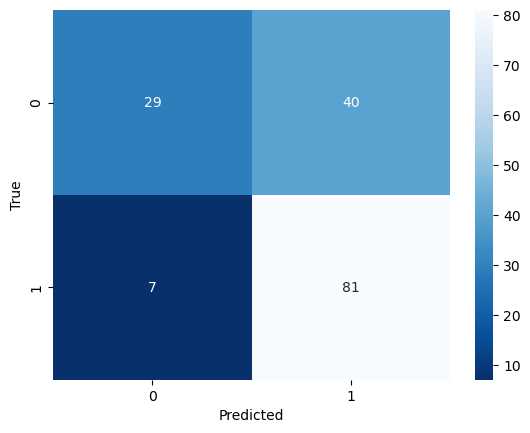

In [161]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True')
plt.xlabel('Predicted'); 

Модель 81 раз правильно предсказывает, что молоко будет вкусным, 29 раз правильно предсказывает, что молоко будет невкусным.

40 раз модель ошибочно выдала невкусное молоко за вкусное (ошибка первого рода False Positive) и 7 раз выдала вкусное молоко за невкусное (ошибка второго рода False Negative).

Для нашей задачи эта молель, очевидно, не подходит, т к нам нужно минимизировать ошибки первого рода: чтобы как можно меньше невкусных образцов модель интерпретировала как вкусное. Ошибки первого рода False Negative для нас в данном случае не критичны.

In [162]:
accuracy = accuracy_score(y_pred, y_test)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print('Метрика accuracy: ', round(accuracy, 3))
print('recall: ',round(recall ,3))
print('precision: ',round(precision,3))


Метрика accuracy:  0.701
recall:  0.92
precision:  0.669


Как уже говорилось в оценке confusion matrix, эта модель дает очень много ошибок первого рода, из-за чего имеем низкую метрику precision = 66,9%. Наша задача - максимально улучшить эту метрику, даже если другие метрики немного "пострадают".

Нам нужно максимально уменьшить ошибки False Positive и тем самым увеличить precision выборки. В этом поможет регулирование порога.
Сперва выведем объекты по возрастанию вероятности их принадлежности к классу 1, т е первыми выведутся образцы с минимальной вероятностью принадлежности к классу 1, т е в начале выйдут те, у которых вероятность быть идентифицированными моделью как 1 минимальна. В конце выведем 10 последних предсказаний с максимальной вероятностью y_proba быть идентифицированными как объект класса 1.

In [163]:
y_proba = clf.predict_proba(X_test)[:,1]

data = pd.DataFrame(zip(y_test, y_pred, y_proba),
             columns = ['y_test', 'y_pred', 'y_proba']).sort_values(by='y_proba', ascending=True)

print(data.head()) 
print()
print(data.tail(15))

     y_test  y_pred   y_proba
46        0       0  0.119685
144       0       0  0.130516
44        0       0  0.148015
141       0       0  0.148728
84        0       0  0.202882

     y_test  y_pred   y_proba
128       1       1  0.789930
51        1       1  0.793295
18        1       1  0.796175
4         1       1  0.803383
25        1       1  0.804365
12        1       1  0.806255
39        1       1  0.812461
11        1       1  0.818293
66        1       1  0.818646
136       1       1  0.824541
8         1       1  0.827255
64        1       1  0.829726
114       1       1  0.830257
85        1       1  0.835689
147       1       1  0.875888


В последних предсказаниях не видим ни одного False Positive случая. Т е при пороге 0.79 False Positive ошибок не встречается. Посмотрим, при каких значениях y_proba начинают встречаться false Positive.

In [69]:
print(data[130:143])

     y_test  y_pred   y_proba
108       0       1  0.758714
19        1       1  0.768402
80        0       1  0.768464
145       1       1  0.770405
111       0       1  0.773594
103       1       1  0.775970
35        1       1  0.776013
138       1       1  0.777296
110       1       1  0.777759
69        1       1  0.783643
14        1       1  0.785354
115       1       1  0.787612
128       1       1  0.789930


Видим, что при значении вероятности (y_proba) 0.7736 модель присвоила целевому признаку значение 1 при значении y_test = 0, значит, при таком пороге уже возможны False Positive случаи. Наша задача - минимизировать, а лучше свести к нулю False Positive, поэтому подберем значение порога более 0.7736.

In [164]:
THRESHOLD = 0.78
y_pred = np.where(clf.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

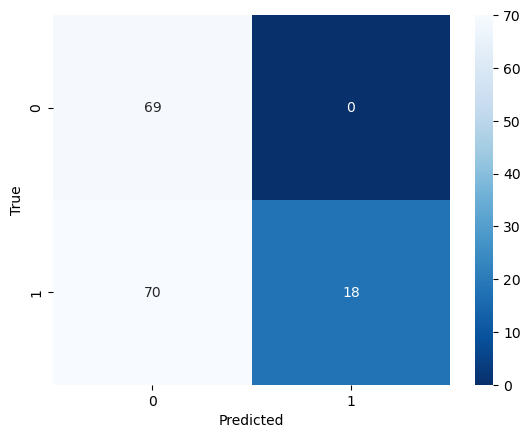

In [165]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True')
plt.xlabel('Predicted'); 

In [166]:
accuracy = accuracy_score(y_pred, y_test)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print('Метрика accuracy модели: ', round(accuracy, 3))
print('recall модели: ',round(recall ,3))
print('precision модели: ',round(precision,3))

Метрика accuracy модели:  0.554
recall модели:  0.205
precision модели:  1.0


При значении  порога 0.78 precision модели равна 1, будем использовать этот порог.

Важно понимать, что при таком значении порога и 100% метрике precision у нас получается очень низкий recall (20,5%), т е почти 80% образцов с реальным значением признака "вкусно" классифицируется как "не вкусно". 

Подготовим данные в cow_buy для прогноза.

In [168]:
cow_buy_ohe = encoder.transform(cow_buy[cat_col_names])
encoder_col_names = encoder.get_feature_names_out() 
cow_buy_ohe = pd.DataFrame(cow_buy_ohe, columns = encoder_col_names) 

cow_buy_scaled = scaler.transform(cow_buy[num_col_names])
cow_buy_scaled = pd.DataFrame(cow_buy_scaled, columns = num_col_names)
 
cow_buy_test = pd.concat([cow_buy_scaled, cow_buy_ohe], axis = 1)

In [170]:
print(X_train.info())
print(cow_buy_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471 entries, 0 to 470
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   spr_category_меньше 0.9    471 non-null    float64
 1   pasture_Холмистое          471 non-null    float64
 2   dad_breed_Соверин          471 non-null    float64
 3   fat_%_category_менее 3.68  471 non-null    float64
 4   age_менее_2_лет            471 non-null    float64
 5   dad_name_Буйный            471 non-null    float64
 6   dad_name_Геркулес          471 non-null    float64
 7   dad_name_Соловчик          471 non-null    float64
 8   eke_squared                471 non-null    float64
 9   raw_protein                471 non-null    float64
 10  protein_%                  471 non-null    float64
 11  sugar_prot_rate            471 non-null    float64
dtypes: float64(12)
memory usage: 44.3 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 

Порядок столбцов в X_train и cow_buy_test разный. Приведем порядок столбцов в cow_buy_test к такому же виду, как в X_train (к порядку, на котором обучалась модель).

In [171]:
cow_buy_test = cow_buy_test[['spr_category_меньше 0.9', 'pasture_Холмистое', 'dad_breed_Соверин',\
                            'fat_%_category_менее 3.68', 'age_менее_2_лет', 'dad_name_Буйный',\
                            'dad_name_Геркулес', 'dad_name_Соловчик', 'eke_squared', 'raw_protein',\
                            'protein_%', 'sugar_prot_rate']]

In [172]:
print(X_train.info())
print(cow_buy_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471 entries, 0 to 470
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   spr_category_меньше 0.9    471 non-null    float64
 1   pasture_Холмистое          471 non-null    float64
 2   dad_breed_Соверин          471 non-null    float64
 3   fat_%_category_менее 3.68  471 non-null    float64
 4   age_менее_2_лет            471 non-null    float64
 5   dad_name_Буйный            471 non-null    float64
 6   dad_name_Геркулес          471 non-null    float64
 7   dad_name_Соловчик          471 non-null    float64
 8   eke_squared                471 non-null    float64
 9   raw_protein                471 non-null    float64
 10  protein_%                  471 non-null    float64
 11  sugar_prot_rate            471 non-null    float64
dtypes: float64(12)
memory usage: 44.3 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 

В ячейке ниже мы посчитаем, выполняется ли условие y_proba > THRESHOLD (вероятность принадлежности к классу 1 больше порога классификации). Если y_proba > THRESHOLD, то значению прогноза присваивается 1 (вкусно), если  y_proba < THRESHOLD,  прогнозу признака  присваивается ноль (не вкусно).
После расчета y_proba и проверки выполнения условия прохождения порога создадим таблицу со столбцами prognose_taste и y_proba.

In [173]:
THRESHOLD = 0.78
prognose = np.where(clf.predict_proba(cow_buy_test)[:,1] > THRESHOLD, 1, 0)
y_proba = clf.predict_proba(cow_buy_test)[:,1]

data = pd.DataFrame(zip(prognose, y_proba),
             columns = ['prognose_taste', 'y_proba'])

display(data) 
print()
print(len(data[data['prognose_taste']==1]), 'образцов из предложенной выборки проходят критерий качества вкуса.')

prognose_taste   y_proba
0                0  0.762612
1                0  0.696863
2                0  0.576308
3                0  0.464953
4                0  0.586926
5                0  0.145765
6                0  0.762612
7                0  0.687572
8                0  0.576308
9                1  0.795332
10               0  0.349435
11               0  0.672518
12               0  0.263552
13               0  0.721153
14               0  0.576308
15               0  0.555551
16               1  0.826316
17               0  0.225084
18               0  0.470019
19               0  0.586926


2 образцов из предложенной выборки проходят критерий качества вкуса.


При заданном пороге 0.78 только 2 коровы проходят критерий качества вкуса, и это точно спрогнозированные значения, т к precision используемой модели равен 1. Но важно понимать, что при таком пороге очень низкий recall - 20,5%, т е только 20,5% из реально вкусных образцов идентифицируются моделью как вкусные, а 80,5% вкусных образцов отсеиваются, идентифицируются как невкусные.


In [174]:
yield_prognose['id'] = range(len(yield_prognose))
data['id'] = range(len(data))
cow_buy['id'] = range(len(cow_buy))

Объединим таблицы с предсказаниями модели линейной регрессии (годового удоя) и модели логистической регрессии (вкус молока). 

Добавим таблицу с прогнозами вкуса молока и удоя коров «ЭкоФермы» в датафрейм с коровами (cow_buy), покупку которых рассматривает фермер.

In [175]:
result_prognose = yield_prognose.merge(data, on = 'id', how = 'left')
result_prognose.drop('y_proba', axis=1, inplace=True)
total_result = cow_buy.merge(result_prognose, on = 'id', how = 'left')
total_result.drop('id', axis = 1, inplace = True)

display(total_result)


breed    pasture dad_breed  dad_name  current_fat_%  protein_%  \
0    Вис Бик Айдиал  Холмистое    Айдиал  Геркулес           3.58      3.076   
1    Вис Бик Айдиал  Равнинное   Соверин    Буйный           3.54      3.081   
2   РефлешнСоверинг  Равнинное   Соверин     Барин           3.59      3.074   
3   РефлешнСоверинг  Холмистое    Айдиал    Буйный           3.40      3.061   
4   РефлешнСоверинг  Равнинное    Айдиал    Буйный           3.64      3.074   
5   РефлешнСоверинг  Равнинное   Соверин  Геркулес           3.63      3.053   
6    Вис Бик Айдиал  Холмистое    Айдиал  Геркулес           3.58      3.076   
7    Вис Бик Айдиал  Равнинное   Соверин    Буйный           3.57      3.079   
8   РефлешнСоверинг  Равнинное   Соверин     Барин           3.59      3.074   
9   РефлешнСоверинг  Холмистое    Айдиал    Буйный           3.40      3.079   
10   Вис Бик Айдиал  Холмистое   Соверин  Соловчик           3.73      3.055   
11  РефлешнСоверинг  Равнинное   Соверин  Геркулес           3.73      3.073   
12   Вис Бик Айдиал  Холмистое    Айдиал  Геркулес           3.68      3.046   
13   Вис Бик Айдиал  Холмистое   Соверин     Барин           3.42      3.075   
14  РефлешнСоверинг  Равнинное   Соверин     Барин           3.59      3.074   
15  РефлешнСоверинг  Холмистое    Айдиал    Буйный           3.40      3.065   
16   Вис Бик Айдиал  Холмистое   Соверин  Соловчик           3.73      3.079   
17  РефлешнСоверинг  Равнинное   Соверин  Геркулес           3.77      3.053   
18   Вис Бик Айдиал  Равнинное   Соверин    Буйный           3.34      3.069   
19  РефлешнСоверинг  Равнинное    Айдиал    Буйный           3.64      3.074   

            age  eke_squared  raw_protein  sugar_prot_rate spr_category  \
0   более_2_лет   233.402006     2019.948           0.9555   больше 0.9   
1   менее_2_лет   233.402006     2019.948           0.9555   больше 0.9   
2   более_2_лет   233.402006     2019.948           0.9555   больше 0.9   
3   более_2_лет   233.402006     2019.948           0.9555   больше 0.9   
4   более_2_лет   233.402006     2019.948           0.9555   больше 0.9   
5   менее_2_лет   233.402006     2019.948           0.9555   больше 0.9   
6   более_2_лет   233.402006     2019.948           0.9555   больше 0.9   
7   более_2_лет   233.402006     2019.948           0.9555   больше 0.9   
8   более_2_лет   233.402006     2019.948           0.9555   больше 0.9   
9   менее_2_лет   233.402006     2019.948           0.9555   больше 0.9   
10  более_2_лет   233.402006     2019.948           0.9555   больше 0.9   
11  более_2_лет   233.402006     2019.948           0.9555   больше 0.9   
12  более_2_лет   233.402006     2019.948           0.9555   больше 0.9   
13  менее_2_лет   233.402006     2019.948           0.9555   больше 0.9   
14  более_2_лет   233.402006     2019.948           0.9555   больше 0.9   
15  более_2_лет   233.402006     2019.948           0.9555   больше 0.9   
16  более_2_лет   233.402006     2019.948           0.9555   больше 0.9   
17  менее_2_лет   233.402006     2019.948           0.9555   больше 0.9   
18  более_2_лет   233.402006     2019.948           0.9555   больше 0.9   
19  более_2_лет   233.402006     2019.948           0.9555   больше 0.9   

    taste fat_%_category  yield_prognose       result  prognose_taste  
0       0     менее 3.68     6450.896377     подходит               0  
1       0     менее 3.68     6149.124244     подходит               0  
2       0     менее 3.68     6083.781231     подходит               0  
3       0     менее 3.68     6580.006820     подходит               0  
4       0     менее 3.68     6380.731289     подходит               0  
5       0     менее 3.68     6403.975905     подходит               0  
6       0     менее 3.68     6450.896377     подходит               0  
7       0     менее 3.68     6368.753827     подходит               0  
8       0     менее 3.68     6083.781231     подходит               0  
9       0     менее 3.68     6217.507

Зададим условие, отбирающее коров, соответствующих обоим условиям: годовой удой больше 6000 кг, значение входит в доверительный интервал и вкус молока проходит критерии.

In [176]:
total_result[(total_result['result'] == 'подходит')&(total_result['prognose_taste'] == 1)]

breed    pasture dad_breed  dad_name  current_fat_%  protein_%  \
9   РефлешнСоверинг  Холмистое    Айдиал    Буйный           3.40      3.079   
16   Вис Бик Айдиал  Холмистое   Соверин  Соловчик           3.73      3.079   

            age  eke_squared  raw_protein  sugar_prot_rate spr_category  \
9   менее_2_лет   233.402006     2019.948           0.9555   больше 0.9   
16  более_2_лет   233.402006     2019.948           0.9555   больше 0.9   

    taste fat_%_category  yield_prognose    result  prognose_taste  
9       0     менее 3.68     6217.507618  подходит               1  
16      0     более 3.68     6384.659306  подходит               1

***Рекомендации фермеру***
С помощью моделей линейной и логистической регрессии мы спрогнозировали для покупки 2 коров, которые удовлетворяют обоим критериям: годовой удой более 6000 кг и молоко проходит критерии качества вкуса. 

## Итоговые выводы:

***1)*** По итогам сравнения трех моделей логистической регрессии лучшей оказалась третья модель. Добиться улучшения качества работы модели получилось с помощью 
- добавления признака имени папы из таблицы с коровами на продажу;
- добавлением признака ЕКЕ в квадрате (по итогу это усилило связь между данным и целевым признаками), сам показатель ЕКЕ убрали, чтобы исключить влияние связи между входными признаками;
- добавили показатель fat_%_category, т к этот признак по сути бинарный, он делит показатели целевого признака на 2 категории. Корреляция с целевым показателем выросла до 94%. Сам показатель жирности убрали.
- добавили показатель spr_category, т к значение 0.9 этого признака делит значения целевого показателя на 2 кластера, то есть по сути это тоже бинарный признак. Перевод в категориальный признак значительно усилил связь с удоем (коэффициент корреляции Фи вырос почти до 100%);
- снизили влияние некоторых признаков, не имеющих корреляции с целевым: убрали признак breed (на графиках и по коэффициентам не было видно влияния этого признака на целевой показатель), убрали признак fat_%, т к его влияние на целевой было значительно меньше, чем fat_%_category.

***2)*** По итогам добавления новых, трансформации и удаления старых признаков мы улучшили точность предскзания модели линейной регрессии (коэффициент детерминации) на 2,3%, с 79,4% до 81,7%. Для дальнейшего улучшения метрик модели можно было бы рекомендовать использование данных из аналогичных выборок, но с бОльшими целевыми показателями удоя, т к во всех рассмотренных моделях начиная с определенного значения целевого признака наблюдался большой разброс ошибок, обусловленный малым количеством тренировочных данных  о коровах с высокими значениями удоя.

***3)*** Для обучения модели логистической регрессии мы использовали те же признаки, что и в лучшей из трех моделей логистической регрессии. При стандартном пороге классификации 0,5 метрики модели были очень низкими. 

Так как в данной задаче было принципиально не ошибиться в прогнозе вкуса молока (чтобы не было вероятности выдать невкусный образец за вкусный), для получения максимально точных прогнозов стояла задача максимизировать метрику precision, т е свести False Positive ошибки к минимуму. При пороге 0.78 метрика precision стала равна 100%, при этом пороге мы отобрали 2 коров, удовлетворяющим критериям качества вкуса.

***4)*** С минимальным риском для себя фермер может купить двух коров с id равными 10 и 16. В теории можно дать рекомендацию собрать больше информации по аналогичным коровам, чье молоко удовлетворяет вкусовому критерию.В исходной выборке из 620 коров только 60% проходили критерий вкуса (в пересчете на коров это 380). Можно было бы улучшить качество модели логистической регрессии, увеличив размер выборки для обучения модели.
